# Differential Expression Analysis - RhithroLoxo

## Set-up

If you've already saved the workspace image from a previous session, jupyter should automatically reload it. You may need to reload the packages though. The .RData file is not on GitHub, so you will have to actually run it the first time through. 

First, make sure you're actually running this from a compute node, not the login. On Poseidon, logins are 'l1' and 'l2', whereas all other nodes start with 'pn'.

In [1]:
Sys.info()

sysname                               release 
                              "Linux"           "3.10.0-693.2.2.el7.x86_64" 
                              version                              nodename 
"#1 SMP Tue Sep 12 22:26:13 UTC 2017"                               "pn094" 
                              machine                                 login 
                             "x86_64"                             "unknown" 
                                 user                        effective_user 
                            "ztobias"                             "ztobias"

Clear environment (if you want to get rid of objects from previous sessions). Or load .RData if you want to recover workspace. (Just note that some objects get overwritten throughout script, so will reflect only the one written last.)

In [2]:
rm(list = ls())
#load(".RData")

Now load in the packages. Specify number of cores you requested for SLURM interactive session under `register(MulticoreParam())`

In [3]:
require(DESeq2)
require(ggplot2)
require(apeglm)
require(ashr)
library("BiocParallel")
register(MulticoreParam(34))
require(VennDiagram)
require(RColorBrewer)
require(pheatmap)
require(dplyr)
require(tibble)
require(tidyr)

Loading required package: DESeq2
Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min


Attaching p

## Data import

Now import the count data, rounding decimals to integers.

In [4]:
path_to_main <- "/vortexfs1/scratch/ztobias/RhithroLoxo_DE/" #change accordingly based on parent file structure
path_to_counts <- "outputs/quant/salmon.isoform.counts.matrix"
path <- paste(path_to_main,path_to_counts,sep="")
all_counts <- read.table(path,header=TRUE)
all_counts <- round(all_counts)
all_counts[] <- sapply(all_counts, as.integer)

Take a look.

In [5]:
head(all_counts)
dim(all_counts)

,AP_C_1,AP_C_2,AP_C_3,AP_C_4,AP_C_5,AP_C_6,AP_P_1,AP_P_2,AP_P_3,AP_P_6,...,NJ_P_7,SC_C_12,SC_C_14,SC_C_2,SC_C_6,SC_C_7,SC_C_9,SC_P_1,SC_P_2,SC_P_3
TRINITY_DN34991_c0_g1_i1,7,43,9,29,55,6,20,10,5,23,...,18,8,7,1,20,10,11,8,3,9
TRINITY_DN157428_c0_g1_i1,0,0,0,0,0,0,0,0,1,0,...,2,5,1,0,2,1,5,0,0,0
TRINITY_DN22619_c0_g1_i1,294,619,417,775,462,214,230,361,104,538,...,435,604,344,166,450,302,466,542,154,257
TRINITY_DN44279_c0_g1_i1,74,105,188,239,77,127,95,138,217,90,...,85,31,153,18,9,51,113,7,33,49
TRINITY_DN11848_c1_g1_i1,3,7,2,0,4,2,3,1,0,2,...,4,3,2,6,7,6,6,2,1,1
TRINITY_DN40042_c0_g1_i1,48,56,47,65,47,26,23,30,23,36,...,32,41,50,37,45,45,37,47,6,20


[1] 146332     83

In [6]:
all_counts["TRINITY_DN34991_c0_g1_i1",]

,AP_C_1,AP_C_2,AP_C_3,AP_C_4,AP_C_5,AP_C_6,AP_P_1,AP_P_2,AP_P_3,AP_P_6,...,NJ_P_7,SC_C_12,SC_C_14,SC_C_2,SC_C_6,SC_C_7,SC_C_9,SC_P_1,SC_P_2,SC_P_3
TRINITY_DN34991_c0_g1_i1,7,43,9,29,55,6,20,10,5,23,...,18,8,7,1,20,10,11,8,3,9


Read in the sample metadata and have a look.

In [7]:
path_to_meta <- paste(path_to_main,"metadata/DESeq2_coldata.txt",sep="")
coldata <- read.table(path_to_meta,header=FALSE,row.names=1)
colnames(coldata) <- c("site","condition","range","sex")
head(coldata)
dim(coldata)

,site,condition,range,sex
AP_C_1,AP,C,Native,F
AP_C_2,AP,C,Native,F
AP_C_3,AP,C,Native,M
AP_C_4,AP,C,Native,M
AP_C_5,AP,C,Native,M
AP_C_6,AP,C,Native,M


[1] 83  4

Make sure the two matrices contain all of the same samples and are in order.

In [8]:
all(rownames(coldata) == colnames(all_counts))

[1] TRUE

## Filtering

EXPLAIN HERE

Create a DESeq dataset just for the purpose of calculating normalized counts

In [9]:
filtering <- DESeqDataSetFromMatrix(countData = all_counts, colData = coldata, design = ~ condition)

Estimate size factors and save normalized counts to object 'norm_mat'

In [10]:
filtering <- estimateSizeFactors(filtering)
norm_mat <- counts(filtering, normalized=TRUE)

Then let's remove the parasitized crabs. This includes all samples with the naming pattern `*_P_*`. The function `grepl()` returns a boolean vector that can be used to index. I will also remove sample MD_C_12, as this was identified to have a latent infection (unidentified infection detected in previous runs of this analysis).

In [11]:
norm_mat_sub <- norm_mat[,!grepl("*_P_*", colnames(norm_mat))]
norm_mat_sub <- subset(norm_mat_sub, select=-c(MD_C_12))

Verify the names you wanted to remove are gone.

In [12]:
colnames(norm_mat_sub)

[1] "AP_C_1"  "AP_C_2"  "AP_C_3"  "AP_C_4"  "AP_C_5"  "AP_C_6"  "FP_C_10"
 [8] "FP_C_11" "FP_C_12" "FP_C_13" "FP_C_5"  "FP_C_9"  "LA_C_1"  "LA_C_2" 
[15] "LA_C_3"  "LA_C_4"  "LA_C_6"  "LA_C_8"  "LA_F_1"  "MA_C_1"  "MA_C_2" 
[22] "MA_C_4"  "MD_C_10" "MD_C_11" "MD_C_1"  "MD_C_4"  "MD_C_7"  "MD_F_4" 
[29] "ML_C_10" "ML_C_2"  "ML_C_3"  "ML_C_5"  "ML_C_7"  "ML_C_9"  "NH_C_11"
[36] "NH_C_12" "NH_C_13" "NH_C_5"  "NH_C_8"  "NH_C_9"  "NJ_C_10" "NJ_C_11"
[43] "NJ_C_12" "NJ_C_13" "NJ_C_14" "NJ_C_6"  "SC_C_12" "SC_C_14" "SC_C_2" 
[50] "SC_C_6"  "SC_C_7"  "SC_C_9"

Column numbers of the parasite samples in `norm_mat_sub` are 19 and 28. Command below finds the index of the maximum column for each row, checks if it matches 19 or 28 (the parasite samples), returns boolean which is used to subset the dataframe.  Let's take a look at a slice of the output to verify it's behavior. Parasite samples follow the naming pattern `*_F_*`.

In [13]:
contam_subset <- norm_mat_sub[max.col(norm_mat_sub) %in% c(19,28),]
dim(contam_subset)
contam_subset[1:20,18:29]

[1] 5757   52

,LA_C_8,LA_F_1,MA_C_1,MA_C_2,MA_C_4,MD_C_10,MD_C_11,MD_C_1,MD_C_4,MD_C_7,MD_F_4,ML_C_10
TRINITY_DN33371_c0_g1_i1,9.041435,0.0000,28.042493,13.686567,11.336672,11.985439,6.7281073,20.236409,14.1915934,5.06316,360.9796,2.552088
TRINITY_DN144663_c0_g1_i1,111.974693,0.0000,138.055348,112.533996,131.001542,303.060378,132.3194429,103.205686,157.8814770,129.53251,360.9796,94.427263
TRINITY_DN44175_c0_g1_i1,4.868465,2081.4567,8.628459,15.207297,16.375193,7.704925,8.2232422,26.307332,20.4004156,2.95351,360.9796,5.954872
TRINITY_DN136684_c0_g1_i1,194.043102,346.9094,47.456526,22.810945,26.452234,33.388008,34.3881038,11.467298,6.2088221,5.48509,0.0000,1.701392
TRINITY_DN3091_c2_g1_i1,98.064793,0.0000,102.462953,72.995024,64.241141,136.120339,118.1156609,176.056758,79.8277131,118.98426,360.9796,128.455106
TRINITY_DN7123_c0_g1_i2,183.610677,15264.0157,264.246564,138.386401,124.703391,145.537470,162.9697094,225.298686,97.5672049,188.18078,28517.3898,149.722507
TRINITY_DN21856_c1_g1_i1,134.926028,346.9094,95.991609,95.805970,105.808938,179.781580,159.2318720,100.507498,129.4982901,106.32636,0.0000,114.843969
TRINITY_DN4690_c0_g1_i2,60.508064,346.9094,74.420461,48.663350,50.385209,51.366166,42.6113460,66.780150,41.6878057,45.14651,0.0000,50.191068
TRINITY_DN3306_c0_g1_i1,474.327582,1387.6378,671.941263,740.595352,641.151778,542.769152,529.2777717,663.754214,406.2343622,601.25026,721.9592,647.379704
TRINITY_DN11641_c0_g1_i3,10.432425,693.8189,14.021246,10.645108,16.375193,37.668522,8.2232422,14.165486,10.6436951,19.40878,0.0000,26.371578


Scrolling through, it's clear that these 5757 transcripts have the highest expression in at least one of the parasite samples. This is indicative of Loxo contamination in the Rhithro assembly. However, because the Loxo externae are female, it could be that by pulling out these transcripts, I am removing transcripts that are generally overexpressed in females relative to males in crustaceans more broadly (that cross-map between Loxo and Rhithro). This could interfere with the investigation of sex-specific differences of infection later on, i.e. if we see a greater/different transcriptional response in males, is it due to host feminization or because we have pulled out these female-specific transcripts early in the pipeline? To investigate this possibility, I'll make a DESeqDataSet using just these transcripts and compare uninfected males and females. 

First I'll remove the actual Loxo externae samples from the original count data.  From the sample metadata as well. Then I'll subset the count data to include just the putative Loxo contamination.

In [14]:
loxo_counts <- all_counts[rownames(contam_subset),]
loxo_counts <- loxo_counts[,-c(29,41)]
coldata <- coldata[-c(29,41),]

We'll also reset the factor levels for `coldata` since we've removed the parasite samples. We'll keep female as the reference level. While we're at it, let's set the factor levels for range to be Native, Invasive, Absent. 

In [15]:
coldata$sex <- factor(coldata$sex, c("F","M"))
coldata$range <- factor(coldata$range, c("Native","Invasive","Absent"))
coldata$sex
coldata$range

[1] F F M M M M F F F M F M M M F F M M F F M F M M F M F F M M M M M M M F M M
[39] F M M M F M F F F M M M M F F F M M M F F F F F M M M F M F F F F F M F M F
[77] F M F M M
Levels: F M

[1] Native   Native   Native   Native   Native   Native   Native   Native  
 [9] Native   Native   Native   Native   Native   Native   Native   Native  
[17] Native   Native   Native   Native   Native   Native   Native   Native  
[25] Native   Native   Native   Native   Native   Native   Absent   Absent  
[33] Absent   Invasive Invasive Invasive Invasive Invasive Invasive Invasive
[41] Invasive Invasive Invasive Invasive Invasive Invasive Invasive Invasive
[49] Absent   Absent   Absent   Absent   Absent   Absent   Absent   Absent  
[57] Absent   Absent   Absent   Absent   Absent   Absent   Absent   Absent  
[65] Absent   Absent   Absent   Absent   Absent   Absent   Absent   Absent  
[73] Invasive Invasive Invasive Invasive Invasive Invasive Invasive Invasive
[81] Invasive
Levels: Native Invasive Absent

Cool. Now we can actually go on to seeing if there is any bias by sex when looking at just the putative Loxo contaminant transcripts. 

In [16]:
dds_loxo <- DESeqDataSetFromMatrix(countData = loxo_counts, colData = coldata, design = ~ condition )
dds_loxo$group <- factor(paste0(dds_loxo$sex, dds_loxo$condition))
design(dds_loxo) <- ~ group
dds_loxo <- DESeq(dds_loxo, parallel=TRUE)

factor levels were dropped which had no samples
estimating size factors
estimating dispersions
gene-wise dispersion estimates: 34 workers
mean-dispersion relationship
final dispersion estimates, fitting model and testing: 34 workers
-- replacing outliers and refitting for 86 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [17]:
resultsNames(dds_loxo)

[1] "Intercept"      "group_FP_vs_FC" "group_MC_vs_FC" "group_MP_vs_FC"

In [18]:
dds_loxo_res <- results(dds_loxo, contrast=c("group", "MC", "FC"), alpha=0.05)
summary(dds_loxo_res)


out of 5757 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 6, 0.1%
LFC < 0 (down)     : 11, 0.19%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Okay so there are 17 transcripts among those that are putative Loxo contaminants that are differentially expressed between uninfected males and females. Let's take a look at some of these.

In [19]:
data.frame(subset(dds_loxo_res, padj < 0.05))

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
TRINITY_DN30863_c0_g1_i1,2.134746,-3.3335580,0.7168228,-4.650463,3.311904e-06,3.177772e-03
TRINITY_DN111414_c0_g1_i1,20.028845,-2.0149533,0.4977213,-4.048356,5.157857e-05,2.284137e-02
TRINITY_DN78440_c0_g1_i1,6.564642,-2.6133972,0.6239985,-4.188147,2.812415e-05,1.619107e-02
TRINITY_DN34429_c0_g1_i1,12.330704,23.8318736,3.7471274,6.360038,2.017034e-10,5.806034e-07
TRINITY_DN10961_c0_g1_i1,48.970627,1.4043726,0.3585702,3.916591,8.981010e-05,3.693120e-02
TRINITY_DN31616_c0_g1_i1,7.782459,-2.4664716,0.6057283,-4.071911,4.662909e-05,2.237031e-02
TRINITY_DN21107_c1_g1_i1,1.859483,-1.8352752,0.4774350,-3.844031,1.210296e-04,4.098631e-02
TRINITY_DN50037_c0_g1_i1,11.953917,1.8294680,0.4059431,4.506710,6.584046e-06,4.738044e-03
TRINITY_DN6508_c0_g1_i1,10.975212,6.2101534,0.9642559,6.440358,1.191918e-10,5.806034e-07
TRINITY_DN86698_c0_g1_i1,8.987877,23.3048343,3.7472225,6.219229,4.996043e-10,9.587407e-07


I'll just use the code below to plot select transcripts. Change gene name as desired in the `plotCounts` function. (This basic ggplot structure will be used throughout and written into custom functions later.)

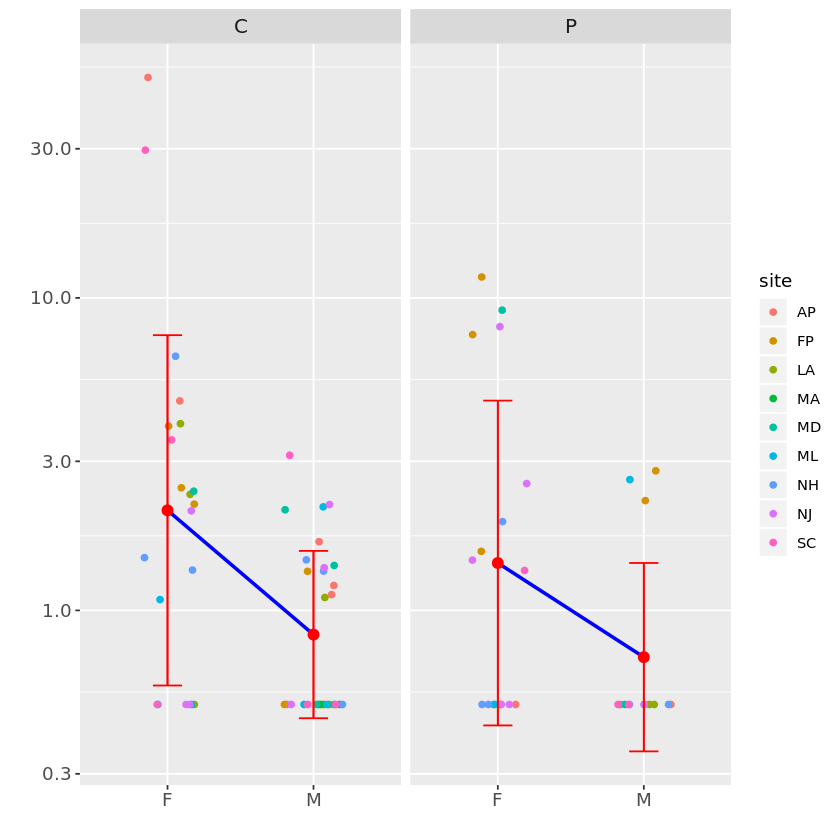

In [20]:
count_plot <- plotCounts(dds_loxo, gene="TRINITY_DN30863_c0_g1_i1", intgroup=c("condition", "site", "sex"), returnData=TRUE)
ggplot(count_plot, aes(x=sex, y=count, color=site)) +
    facet_grid(.~condition) +
    theme(strip.text.x = element_text(size = 12), 
    axis.text.x = element_text(size=11), 
    axis.text.y = element_text(size=11)) +
    xlab("") +
    ylab("") +
    geom_point(position=position_jitter(w=0.2,h=0), show.legend = TRUE) + 
    geom_smooth(method = "lm", se=F, aes(group=1), show.legend = FALSE, color = "blue") +
    stat_summary(fun.data=mean_sdl, fun.args = list(mult=1), geom="pointrange", color="red") +
    stat_summary(fun.data=mean_sdl, fun.args = list(mult=1), geom="errorbar", color="red", width=0.2) +
    scale_y_log10()

While some over these are underexpressed in males relative to females, which would indicate that they might be reflective of general sex-specific expression among crustaceans, the number is pretty insignificant relative to the patterns that will emerge later on regarding sex-specific response to infection. I am going to proceed with discarding these putative Loxo contaminant transcripts. Furthermore, many of these transcripts have very low mean expression, and will be discarded later on during an expression-level filtering anyway. 

Okay now I'm going to save the rownames of the putative Loxo contamination for use later:

In [21]:
contam_IDs <- rownames(contam_subset)
length(contam_IDs)

[1] 5757

Here are the 5757 transcripts that have higher expression in a parasite sample than any of the "clean" samples. I am going to move on to a base parasitized vs. control analysis for the purpose of further filtering, for reasons that will become apparent. I'll include site in the design to account for site-specific differences. First we have to remove the loxo samples from `all_counts`, as we did for the loxo contaminant subset.

In [22]:
all_counts <- all_counts[,-c(29,41)]
dds <- DESeqDataSetFromMatrix(countData = all_counts, colData = coldata, design = ~ site + condition)
dds <- DESeq(dds, parallel=TRUE)

factor levels were dropped which had no samples
estimating size factors
estimating dispersions
gene-wise dispersion estimates: 34 workers
mean-dispersion relationship
-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.
final dispersion estimates, fitting model and testing: 34 workers


Let's visualize the data using some PCAs. This will be helpful for identifying sample outliers.

First we'll apply a variance stabilizing transformation to our normalized counts. 

In [23]:
vsd <- vst(dds, blind=FALSE)

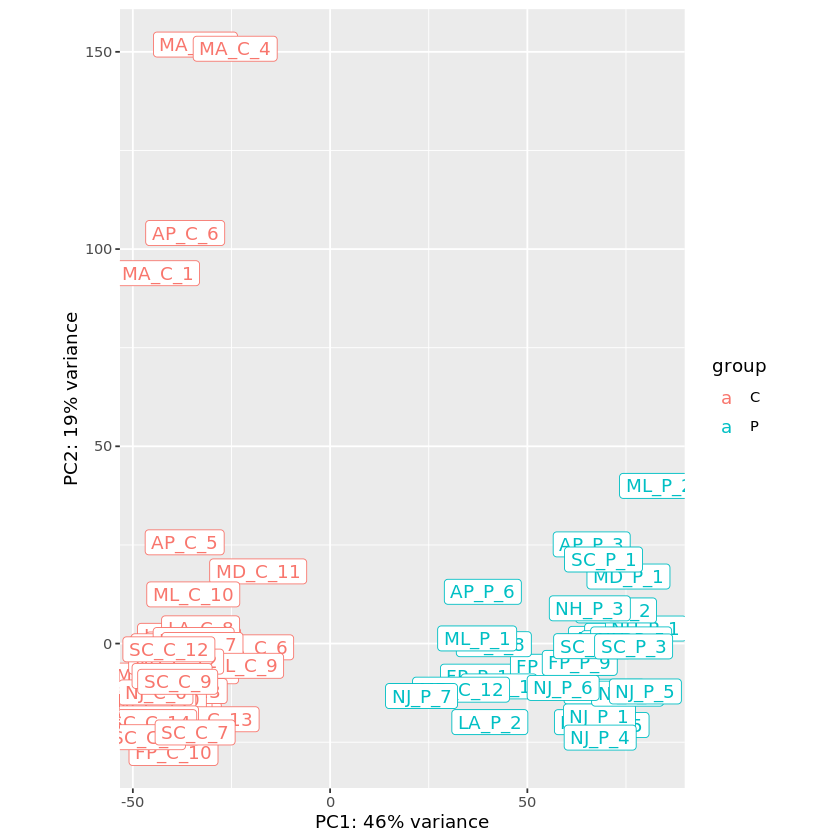

In [24]:
PCA <- plotPCA(vsd, intgroup="condition")
PCA + geom_label(aes(label = name))

You can see that PCA 1 clearly separates the sample according to infection status (whether this is due to a crab response or contamination from parasite remains to be seen...). Along the second PCA axis, you can see four extreme outlier at the upper left corner. Let's investigate this a little more closely by looking at the expression of particular high variance transcripts. 

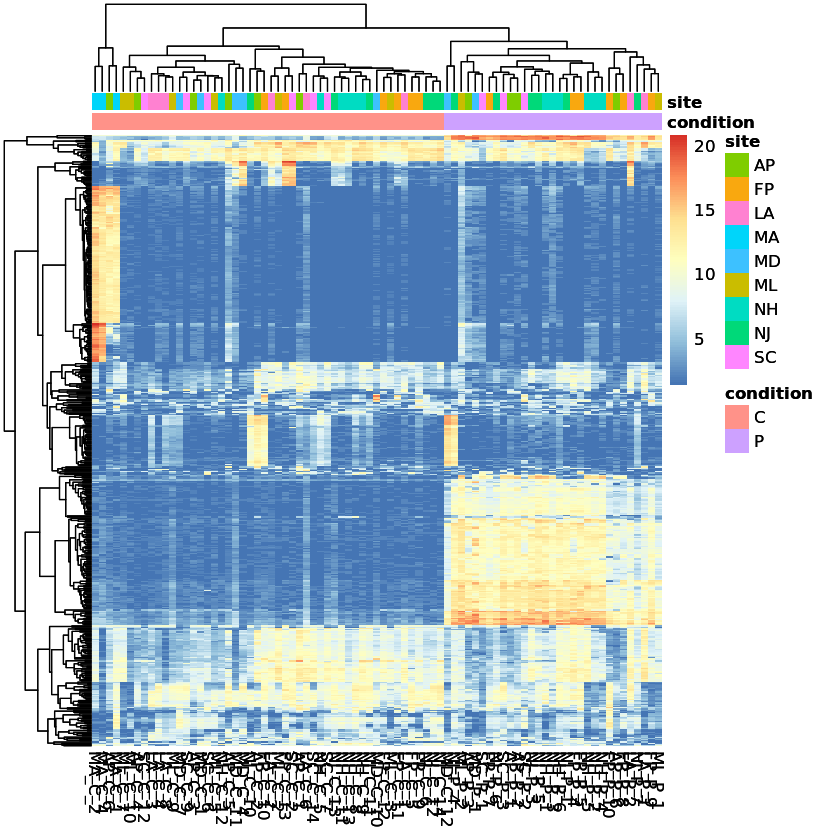

In [25]:
topVarGenes <- head(order(rowVars(assay(vsd)), decreasing = TRUE), 500)
df <- as.data.frame(colData(dds)[,c("condition","site")])
vsd_df <- assay(vsd)
heatmap <- pheatmap(vsd_df[topVarGenes,], cluster_rows=TRUE, show_rownames=FALSE,
         cluster_cols=TRUE, annotation_col=df)
heatmap

Looking at the top 500 highest variance transcripts, you can see that the transcript cluster in the mid-top left separates samples in the same way as PCA axis 2 from above, with MA_C_1, MA_C_2, MA_C_4, and AP_C_6 having really high expression. Let's figure out what those are. 

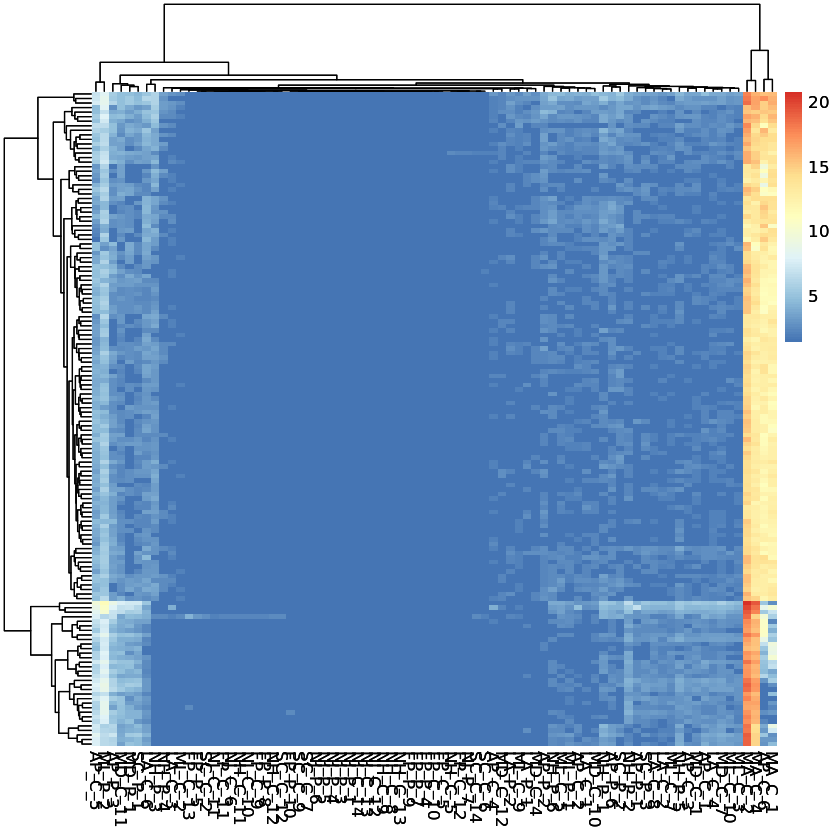

In [26]:
idx <- sort(cutree(heatmap$tree_row, k=10)) #separate transcripts by cluster assignment
idx <- names(which(idx==7)) #after searching, cluster 7 is the one with the transcripts we want
heatmap <- pheatmap(vsd_df[idx,], cluster_rows=TRUE, show_rownames=FALSE, cluster_cols=TRUE)
heatmap

Okay now we found the cluster that has all of these transcripts. Let's get the names and search annotations to see if there is anything we can tell about these transcripts. Load in annotations.

In [27]:
annot <- read.table("../EnTAP/entap_outfiles/similarity_search/DIAMOND/overall_results/best_hits_lvl0.tsv", sep="\t", fill=TRUE, header=TRUE, quote="", stringsAsFactors = FALSE)

In [28]:
outlier_annot <- annot[annot[,1] %in% rownames(vsd[idx,]),] #get matching annotations
head(outlier_annot[order(outlier_annot[,11]),c(1,2,3,11,12,13,14)], 20) #show results

,Query.Sequence,Subject.Sequence,Percent.Identical,E.Value,Coverage,Description,Species
18386,TRINITY_DN15974_c0_g1_i1,sp|Q14562|DHX8_HUMAN,47.6,5.0e-306,98.4,sp|Q14562|DHX8_HUMAN ATP-dependent RNA helicase DHX8 OS=Homo sapiens OX=9606 GN=DHX8 PE=1 SV=1,homo sapiens
17057,TRINITY_DN764_c0_g1_i1,sp|P49951|CLH1_BOVIN,32.7,5.5e-270,92.0,sp|P49951|CLH1_BOVIN Clathrin heavy chain 1 OS=Bos taurus OX=9913 GN=CLTC PE=1 SV=1,bos taurus
14913,TRINITY_DN3369_c0_g1_i1,tr|A0A2P2I4J8|A0A2P2I4J8_9CRUS,47.1,2.8e-228,93.9,tr|A0A2P2I4J8|A0A2P2I4J8_9CRUS Piwi-like protein 4 (Fragment) OS=Hirondellea gigas OX=1518452 PE=2 SV=1,hirondellea gigas
5717,TRINITY_DN11670_c0_g1_i10,XP_013782023.2,38.0,1.7e-216,78.8,XP_013782023.2 U5 small nuclear ribonucleoprotein 200 kDa helicase-like [Limulus polyphemus],limulus polyphemus
10292,TRINITY_DN4882_c0_g1_i1,sp|O02192|HSP83_DROAV,55.1,2.0e-192,94.9,sp|O02192|HSP83_DROAV Heat shock protein 83 OS=Drosophila auraria OX=47315 GN=Hsp83 PE=3 SV=1,drosophila auraria
4276,TRINITY_DN3073_c0_g1_i4,tr|A0A2U5IDQ7|A0A2U5IDQ7_MACRS,55.6,3.8e-180,87.1,tr|A0A2U5IDQ7|A0A2U5IDQ7_MACRS Glucose regulated protein 78 OS=Macrobrachium rosenbergii OX=79674 GN=GRP78 PE=2 SV=1,macrobrachium rosenbergii
13623,TRINITY_DN129176_c0_g1_i1,XP_018497583.1,36.6,7.0e-180,96.7,XP_018497583.1 probable phospholipid-transporting ATPase IIA [Galendromus occidentalis],galendromus occidentalis
18478,TRINITY_DN9317_c0_g1_i1,tr|A0A2P2I7L9|A0A2P2I7L9_9CRUS,57.6,9.5e-172,81.6,tr|A0A2P2I7L9|A0A2P2I7L9_9CRUS Lysine--tRNA ligase (Fragment) OS=Hirondellea gigas OX=1518452 PE=2 SV=1,hirondellea gigas
11987,TRINITY_DN2622_c0_g1_i2,tr|L1J5W8|L1J5W8_GUITC,65.1,8.6e-158,78.6,tr|L1J5W8|L1J5W8_GUITC Adenosylhomocysteinase OS=Guillardia theta (strain CCMP2712) OX=905079 GN=GUITHDRAFT_110013 PE=3 SV=1,guillardia theta (strain ccmp2712)
10791,TRINITY_DN3294_c0_g1_i1,tr|A0A2P2I3G1|A0A2P2I3G1_9CRUS,63.7,1.3e-145,93.1,tr|A0A2P2I3G1|A0A2P2I3G1_9CRUS 60S ribosomal protein (Fragment) OS=Hirondellea gigas OX=1518452 PE=2 SV=1,hirondellea gigas


There doesn't seem to be anything special about these transcripts, though it's hard to tell just from the reference IDs. 

I am going to remove these outlier samples. They are contributing too much variation and will present issues when trying to fit the DESeq2 models and cause issues with count normalization. 

In [29]:
all_counts <- all_counts[,!(colnames(all_counts) %in% c("MA_C_1","MA_C_2","MA_C_4","AP_C_6"))]
all_counts[1:6,1:6]
dim(all_counts)

,AP_C_1,AP_C_2,AP_C_3,AP_C_4,AP_C_5,AP_P_1
TRINITY_DN34991_c0_g1_i1,7,43,9,29,55,20
TRINITY_DN157428_c0_g1_i1,0,0,0,0,0,0
TRINITY_DN22619_c0_g1_i1,294,619,417,775,462,230
TRINITY_DN44279_c0_g1_i1,74,105,188,239,77,95
TRINITY_DN11848_c1_g1_i1,3,7,2,0,4,3
TRINITY_DN40042_c0_g1_i1,48,56,47,65,47,23


[1] 146332     77

Okay now you can see the four of them were removed. Now make sure the coldata matches.

In [30]:
coldata <- coldata[colnames(all_counts),]
all(rownames(coldata) == colnames(all_counts))

[1] TRUE

Okay good let's make another `dds` object to continue with our filtering. We'll just overwrite the existing one.

In [31]:
dds <- DESeqDataSetFromMatrix(countData = all_counts, colData = coldata, design = ~ site + condition)

factor levels were dropped which had no samples


In [32]:
dds <- DESeq(dds, parallel=TRUE)

estimating size factors
estimating dispersions
gene-wise dispersion estimates: 34 workers
mean-dispersion relationship
final dispersion estimates, fitting model and testing: 34 workers


In [33]:
res <- results(dds, alpha=0.05)
summary(res)


out of 143763 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 1556, 1.1%
LFC < 0 (down)     : 1452, 1%
outliers [1]       : 2244, 1.6%
low counts [2]     : 38171, 27%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Here we see that there are 1556 transcripts deemed significantly upregulated in parasitized crabs, and 1452 significantly downregulated, according the the Wald test.

As mentioned earlier, it is my suspicion that some of these upregulated transcripts are contamination from Loxo. Let's have a look.

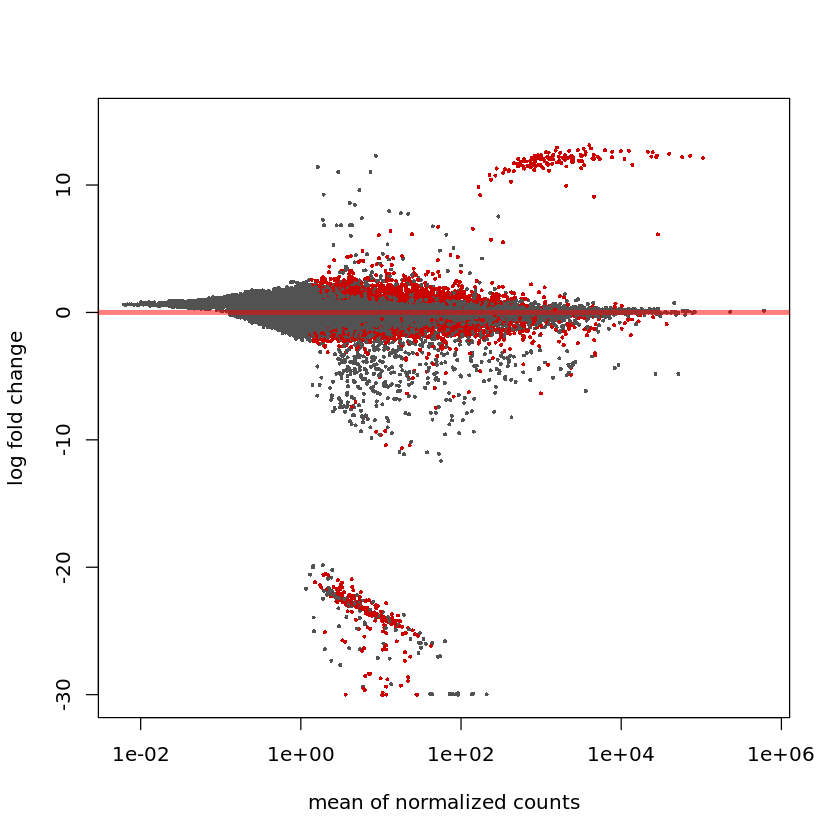

In [34]:
plotMA(res, ylim=c(-30,15))

Here we see the pattern I have alluded to, where there is a cloud of extremely overexpressed (>10 LFC) in the infected relative to the control. It is my suspicion that these represent contamination from Loxo rather than an actually response by the crabs. 

We also see a cloud of extremely *under*expressed transcripts (<-20 LFC). I will deal with these after the Loxo contamination (but I can tell you now that these are contamination from trematodes and perhaps other parasites, mostly in three NH control crabs \[hence the lower count means\]). They are underexpressed in parasitized crabs (overexpressed in control) because the transcriptome was made from just control crabs. 

Let's see if the *over*expressed ones match the transcript IDs we pulled out earlier as possible Loxo contaminant transcripts. 

First let's make an ordered data.frame of the significant transcripts.

In [35]:
res_sig <- data.frame(subset(res, padj < 0.05))
res_sig <- res_sig[order(-res_sig$log2FoldChange),]
head(res_sig)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
TRINITY_DN54766_c0_g2_i1,4010.915,13.12421,0.7753782,16.92621,2.883681e-64,2.365259e-61
TRINITY_DN57720_c0_g1_i1,1575.005,12.94124,0.4590987,28.18837,8.119774e-175,2.208322e-171
TRINITY_DN106284_c0_g1_i1,3394.871,12.86722,0.4778477,26.92745,1.048112e-159,1.719370e-156
TRINITY_DN81798_c0_g1_i1,4201.153,12.86509,0.5721838,22.48419,5.927665e-112,5.373793e-109
TRINITY_DN120239_c0_g1_i1,2870.103,12.72382,0.4719586,26.95961,4.401278e-160,7.456776e-157
TRINITY_DN114680_c0_g1_i1,6258.685,12.72324,0.4605925,27.62363,5.789095e-168,1.300634e-164


You can see that there are some extremely significant, extremely overexpressed transcripts at the top, many of which have high rates of expression overall. These are likely contamination from Loxo. I am not sure how they made it into the transcriptome. It's hard to think of a biological reason. I am thinking this is due to index hopping during sequencing. If there were parasitizied and unparasitized crabs on the same lane (there were), then even a small amount of index hopping could have led to parasite reads being built into the txm, either as chimeras with crab sequences or alone. 

I am going to compare the list of transcripts I made earlier to these to see how much of an overlap there is. 

There are 3008 significant transcripts, 1556 up and 1452 down. There were 5757 transcripts that had higher expression in one of the two parasite samples than any of the clean samples. Let's look at the intersect. 

In [36]:
contam_intersect <- intersect(contam_IDs, rownames(res_sig))
length(contam_intersect)

[1] 472

Okay so there are 472 transcripts that came up as significant that were also identified as potential contamination. Let's see what the distribution of LFCs look like for these transcripts.

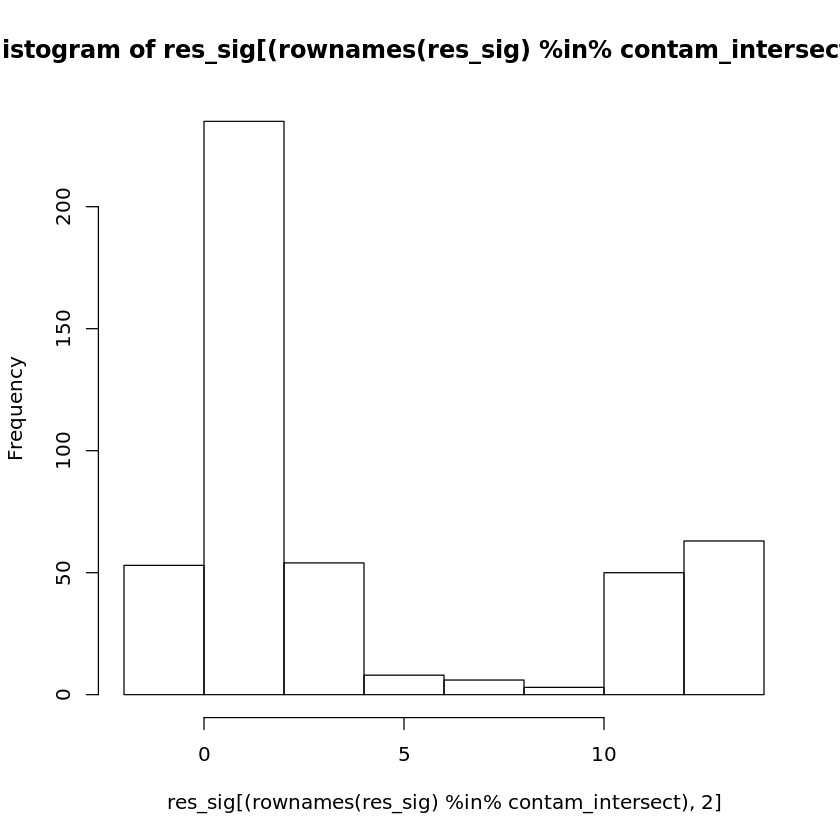

In [37]:
hist(res_sig[(rownames(res_sig) %in% contam_intersect),2])

It shows a bimodal pattern. Most of these transcripts are overexpressed, but a subset (~100) are extremely enriched. It is these that are most likely to be contamination. We will still consider all of these putative contamination and slate them for removal, as I believe it is more prudent to be liberal with what we discard.

 Let's take a look at the significant results table with the putative Loxo contaminants removed.

In [38]:
head(res_sig[!(rownames(res_sig) %in% contam_intersect),],n=10)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
TRINITY_DN94855_c0_g1_i1,818.201065,12.193334,0.4458675,27.347438,1.158387e-164,2.258811e-161
TRINITY_DN103226_c0_g1_i1,765.502580,12.154358,0.4829401,25.167423,9.110431e-140,1.082235e-136
TRINITY_DN121942_c0_g1_i1,730.858665,11.876852,0.4697338,25.284221,4.763849e-141,5.861123e-138
TRINITY_DN128205_c0_g1_i1,3066.539826,11.869465,0.4592484,25.845413,2.739869e-147,3.725789e-144
TRINITY_DN115787_c0_g1_i1,737.555963,11.577339,0.4599799,25.169227,8.705250e-140,1.046128e-136
TRINITY_DN122219_c0_g1_i1,615.779581,11.296135,0.4524007,24.969311,1.317671e-137,1.530098e-134
TRINITY_DN128046_c0_g1_i1,165.456910,9.850894,0.4245390,23.203740,4.174120e-119,3.851669e-116
TRINITY_DN146992_c0_g1_i1,5.882334,4.832828,0.8400757,5.752848,8.775248e-09,1.421480e-06
TRINITY_DN22600_c0_g1_i1,73.960221,4.524784,1.0450118,4.329888,1.491853e-05,1.221711e-03
TRINITY_DN51295_c0_g1_i1,18.504519,4.414598,0.6130850,7.200630,5.993500e-13,1.364353e-10


A lot of those transcripts are now removed. There are just around 7 of them left, depending on where you draw the line.

I am going to repeat visualization with all of putative Loxo contaminant transcripts removed. 

In [39]:
res2 <- results(subset(dds, !rownames(dds) %in% contam_IDs), alpha=0.05)

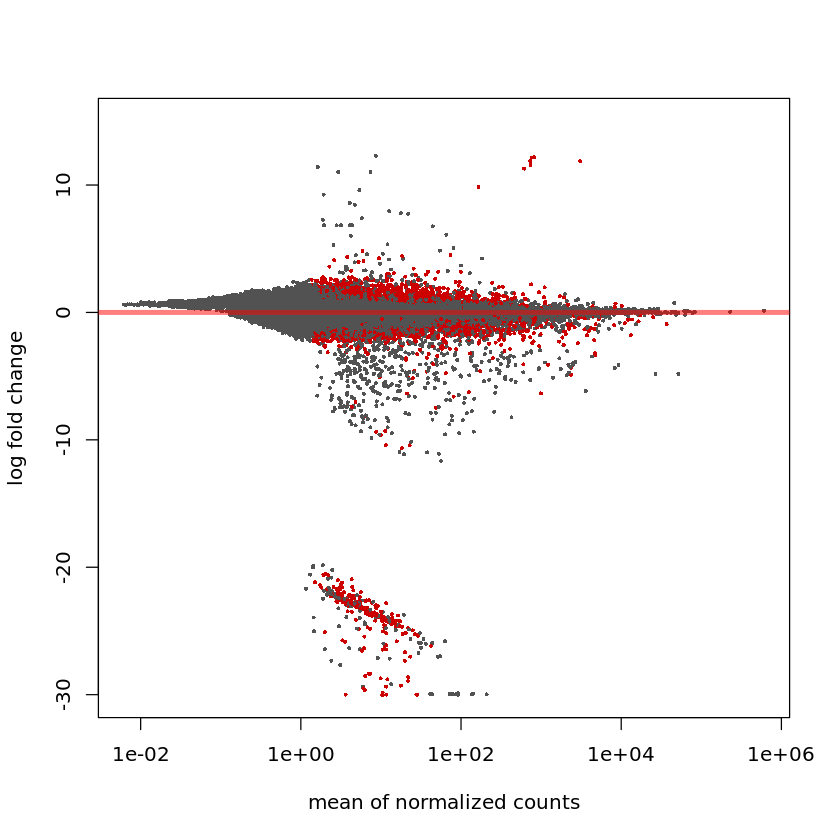

In [40]:
plotMA(res2, ylim=c(-30,15))

You can see now that the big cloud of points at the top right has mostly disappeared. A few points remain. I am still going to consider these as contamination and remove them manually by thresholding.

But first, let's look at the identity of the *under*expressed transcripts. Let's make a subset of the results without these transcripts, and then get the names of those transcripts. 

In [41]:
extra_under <- subset(res2, log2FoldChange < -15)
extra_under <- rownames(extra_under)
length(extra_under)

[1] 400

Okay so there are 400 that are extremely underexpressed.

Now we'll make another vsd object and use the list of transcripts to plot just those that had extremely low LFCs.

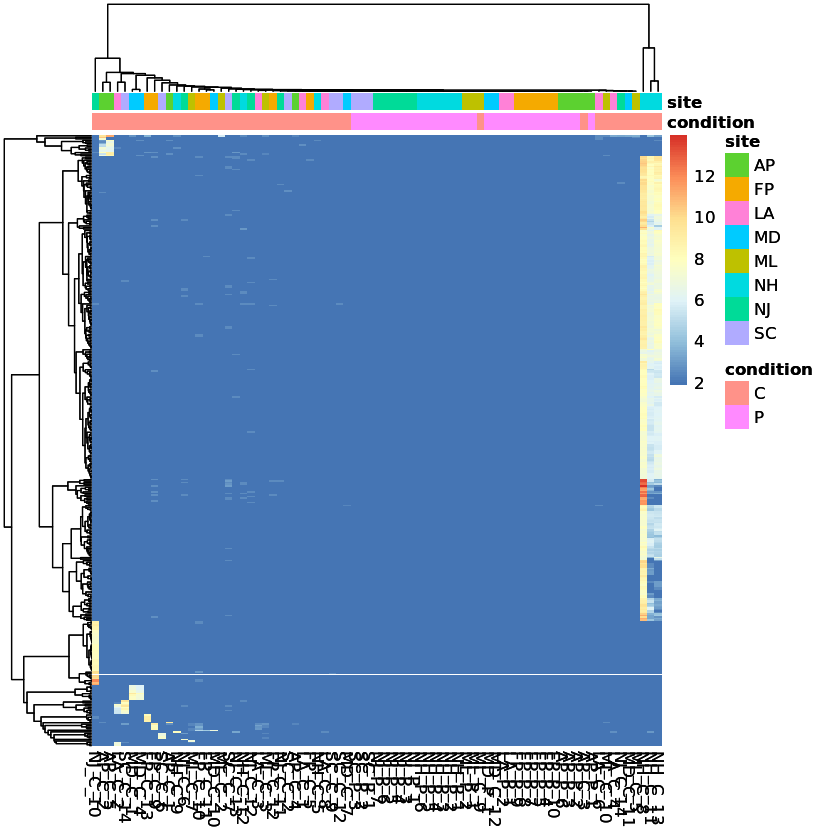

In [42]:
df <- as.data.frame(colData(dds)[,c("condition","site")])
vsd <- vst(dds, blind=TRUE)
vsd_df <- assay(vsd)
heatmap3 <- pheatmap(vsd_df[extra_under,], cluster_rows=TRUE, show_rownames=FALSE,
         cluster_cols=TRUE, annotation_col=df)
heatmap3

It's clear that expression of these transcripts occurs in just a few crabs. It's difficult to see the sample names, but it is mostly in three control samples from NH (NH_C_8, NH_C_11, NH_C_13) and one from NJ (NJ_C_10). So these transcripts are only represented in a few samples. 

Let's use the annotations to figure out the identity of these transcripts.

In [43]:
low_annot <- annot[annot$Query.Sequence %in% extra_under,c(1,2,3,11,13,14)]
low_annot <- low_annot[order(low_annot$E.Value),]
low_annot

,Query.Sequence,Subject.Sequence,Percent.Identical,E.Value,Description,Species
21091,TRINITY_DN110752_c0_g1_i1,sp|P79384|PCCB_PIG,75.5,1.6e-211,"sp|P79384|PCCB_PIG Propionyl-CoA carboxylase beta chain, mitochondrial OS=Sus scrofa OX=9823 GN=PCCB PE=1 SV=1",sus scrofa
2645,TRINITY_DN63964_c0_g1_i1,sp|O18413|PRS8_DROME,91.6,1.4e-161,sp|O18413|PRS8_DROME 26S proteasome regulatory subunit 8 OS=Drosophila melanogaster OX=7227 GN=Rpt6 PE=1 SV=2,drosophila melanogaster
8370,TRINITY_DN59531_c0_g1_i1,sp|O16797|RL3_DROME,68.3,2.7e-161,sp|O16797|RL3_DROME 60S ribosomal protein L3 OS=Drosophila melanogaster OX=7227 GN=RpL3 PE=1 SV=3,drosophila melanogaster
16458,TRINITY_DN111470_c0_g1_i1,sp|P29845|HSP7E_DROME,75.8,8.1e-161,sp|P29845|HSP7E_DROME Heat shock 70 kDa protein cognate 5 OS=Drosophila melanogaster OX=7227 GN=Hsc70-5 PE=1 SV=2,drosophila melanogaster
13953,TRINITY_DN93421_c0_g1_i1,sp|P06744|G6PI_HUMAN,71.3,2.4e-152,sp|P06744|G6PI_HUMAN Glucose-6-phosphate isomerase OS=Homo sapiens OX=9606 GN=GPI PE=1 SV=4,homo sapiens
10393,TRINITY_DN40137_c0_g1_i1,sp|Q9V3H2|PSDE_DROME,78.5,1.4e-133,sp|Q9V3H2|PSDE_DROME 26S proteasome non-ATPase regulatory subunit 14 OS=Drosophila melanogaster OX=7227 GN=Rpn11 PE=1 SV=1,drosophila melanogaster
18555,TRINITY_DN39476_c0_g1_i1,sp|P18603|ACT4_ARTSX,60.3,3.5e-125,"sp|P18603|ACT4_ARTSX Actin, clone 403 OS=Artemia sp. OX=6662 PE=2 SV=1",artemia sp.
12355,TRINITY_DN144489_c0_g1_i1,KAF0293544.1,66.2,9.4e-120,"KAF0293544.1 Phosphoenolpyruvate carboxykinase, cytosolic [GTP] [Amphibalanus amphitrite]",amphibalanus amphitrite
18359,TRINITY_DN126941_c0_g1_i1,sp|P63245|RACK1_RAT,75.3,3.3e-114,sp|P63245|RACK1_RAT Receptor of activated protein C kinase 1 OS=Rattus norvegicus OX=10116 GN=Rack1 PE=1 SV=3,rattus norvegicus
1906,TRINITY_DN62348_c0_g1_i1,EDX17682.1,76.4,9.1e-114,EDX17682.1 GD15970 [Drosophila simulans],drosophila simulans


The taxonomic identity of the matches is not revealing here. However, on previous runs of the annotation pipeline, I did not remove the sequences listed as contamination by EnTAP from the transcriptome prior to creating the expression matrix. When these were left in, the vast majority of the transcripts in this underexpressed cloud were flatworm, nematode, and fungal sequences, all known pathogens of crabs. I decided to remove these contaminants earlier in the pipeline, so their identity is not revealed here. If you aren't convinced, skip the `remove_EnTAP_contam` step in the Snakemake pipeline. 

Okay, now I am going to remove all of these transcripts, not just those that map because many are lacking annotation. For removing both the putative Loxo (upper) contaminants, I am going to get the rownames of the 7 remaining transcripts that fell into that cloud and exclude them. For the other pathogen (lower) contaminants, I am going to set a threshold of -15 to remove the whole cloud. Let's look and see what that would remove, after already having flagged the putative Loxo for removal.

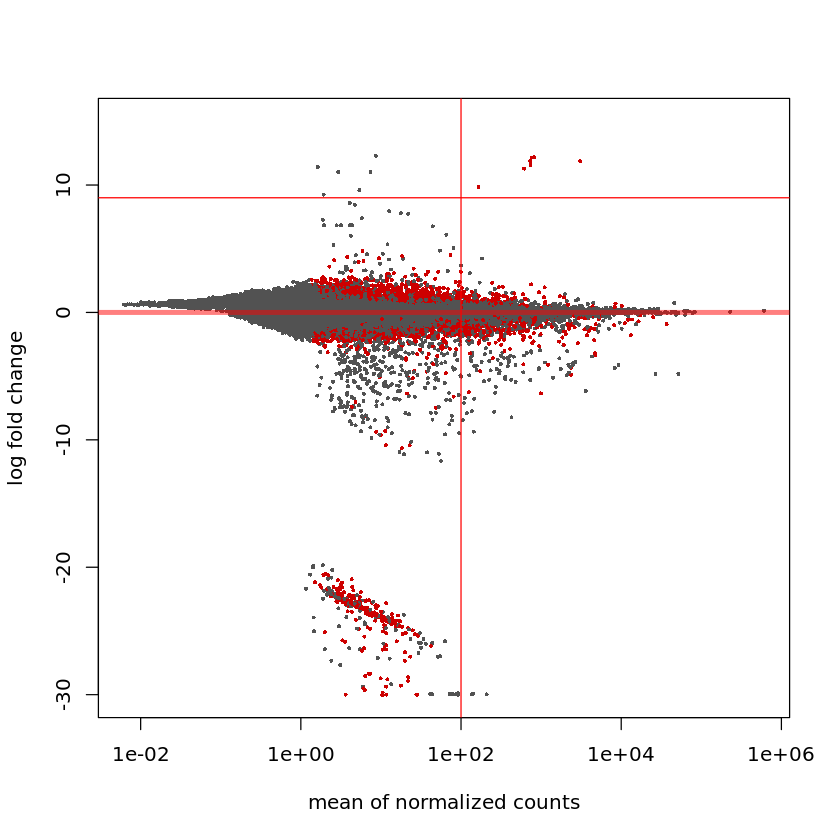

In [44]:
plotMA(res2, ylim=c(-30,15))
abline(h=9,col="red")
abline(v=100,col="red")
abline(v=-20,col="red")

So I'm going to get rid of the 7 transcripts in the very upper right section. These are the putative Loxo contaminants that fell into that cloud of points that had mostly been previously identified as Loxo contamination from the expression comparison. And I am going to get rid of everything below the -15 line. These are the other pathogen contaminants. I got the transcript names for the 7 transcripts in the upper right from the first 7 entries of the dataframe displayed after the histogram above (which shows the extremely overexpressed transcripts that didn't intersect with the loxo contam list, but nonetheless are likely contamination).

In [45]:
contam_high <- rownames(head(res_sig[!(rownames(res_sig) %in% contam_intersect),],n=7))
contam_low <- rownames(subset(res2, res2$log2FoldChange < -15))
contam_add <- c(contam_high,contam_low)
length(contam_add)

[1] 407

Okay here are the 407 remaining transcripts we deem to be contamination. I am going to add them to the list of contam_IDs, which will be used for removal from the intial counts object. Then the analysis will be re-run.

This is all to account for renormalization after removal, since many of these contigs had high mean expression across samples, especially the Loxo contaminants. I also want to have all of the putative contaminant transcripts removed before I do the WGCNA analysis. Because it looks for co-expression patterns among transcripts, if I leave in transcripts that are actually just contaminants, it will likely assign transcripts to modules not based on any functional relevance to particular pathways, but rather just to infection status. 

In [46]:
contam_IDs <- c(contam_IDs, contam_add)
length(contam_IDs)

[1] 6164

Okay so there are 6164 transcripts that we are going to remove because they were flagged as contamination. Let's do that now.

In [47]:
counts_clean <- all_counts[!rownames(all_counts) %in% contam_IDs,]
dim(counts_clean)

[1] 140168     77

So we've removed 6164 from the original 146332, for 140168. Now I am going to do expression-level based filtering to removed lowly expressed transcripts. I am doing this for a few reasons. First, such lowly expressed transcripts are ostensibly less biologically meaningful. Second, they are more likely to be latent contamination from other taxa. Third, they were less likely to be annotated and thus are uninformative. And lastly, on previous runs of this analysis, it was apparent that some transcripts that were deemed significantly differentially expressed were due to extremely high expression in just a small handful of samples, with zero or very minimal expression in other samples. While such transcripts were already revealed above, this comes into play later when looking at the effect of infection *within* ranges. In this instance, contrasting patterns among ranges precluded them from being removed in the procedure above. Furthermore, WGCNA will use a pared down expression matrix, as [suggested](https://horvath.genetics.ucla.edu/html/CoexpressionNetwork/Rpackages/WGCNA/faq.html) by the creators. Removing them now will allow me to conduct DE analysis and WGCNA on the identical dataset. 

I am going to remove all transcripts that have less than a count of 10 in over 90% of samples (69). Again, I'll make a DESeqDataSet object for the purpose of normalizing counts.

In [48]:
dds <- DESeqDataSetFromMatrix(countData = counts_clean, colData = coldata, design = ~ condition)

factor levels were dropped which had no samples


Then I'll get the normalized counts and save it to the `norm_mat` object, overwriting.

In [49]:
dds <- estimateSizeFactors(dds)
norm_mat <- counts(dds, normalized=TRUE)

Here I'll get the dimensions before and after removal to see how many were removed.

In [50]:
dim(norm_mat)
remove <- rowSums(norm_mat < 10 ) > 69
norm_mat <- norm_mat[!remove,]
dim(norm_mat)

[1] 140168     77

[1] 60488    77

So this would result in 60488 transcripts. Still a lot. You can see that a huge number of transcripts (79680 to be precise) were only meaningfully expressed in a small number of samples. Their removal should help in cutting through any confouding signals generated from processes/contamination in just a handful of crabs.

Now we'll remove it from the main count matrix and finally proceed with the actual analyses!

In [51]:
counts_clean <- counts_clean[rownames(norm_mat),]
dim(counts_clean)

[1] 60488    77

## Parasitized vs. control differential expression 

Here we'll just do a base comparison between infected and uninfected, using all 77 remaining samples. Let's just verify that everything matches up.

In [52]:
all(rownames(coldata) == colnames(counts_clean))

[1] TRUE

Good. Create new dds object without the contaminant and lowly expressed transcripts.

In [53]:
dds_clean <- DESeqDataSetFromMatrix(countData = counts_clean, colData = coldata, design = ~site + condition)

factor levels were dropped which had no samples


Here we'll use a likelihood ratio test to control for site-specific effects.

In [54]:
dds_clean <- DESeq(dds_clean, parallel=TRUE, test="LRT", reduced=~site)

estimating size factors
estimating dispersions
gene-wise dispersion estimates: 34 workers
mean-dispersion relationship
final dispersion estimates, fitting model and testing: 34 workers


In [55]:
resultsNames(dds_clean)

[1] "Intercept"        "site_FP_vs_AP"    "site_LA_vs_AP"    "site_MD_vs_AP"   
[5] "site_ML_vs_AP"    "site_NH_vs_AP"    "site_NJ_vs_AP"    "site_SC_vs_AP"   
[9] "condition_P_vs_C"

In [56]:
res_clean <- results(dds_clean, alpha=0.05) #by default, it takes the last factor (P vs. C)
summary(res_clean)


out of 60488 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 852, 1.4%
LFC < 0 (down)     : 743, 1.2%
outliers [1]       : 224, 0.37%
low counts [2]     : 0, 0%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Now you can see that we have 852 significantly upregulated transcripts and 743 significantly downregulated transcripts.

Plot the LFCs

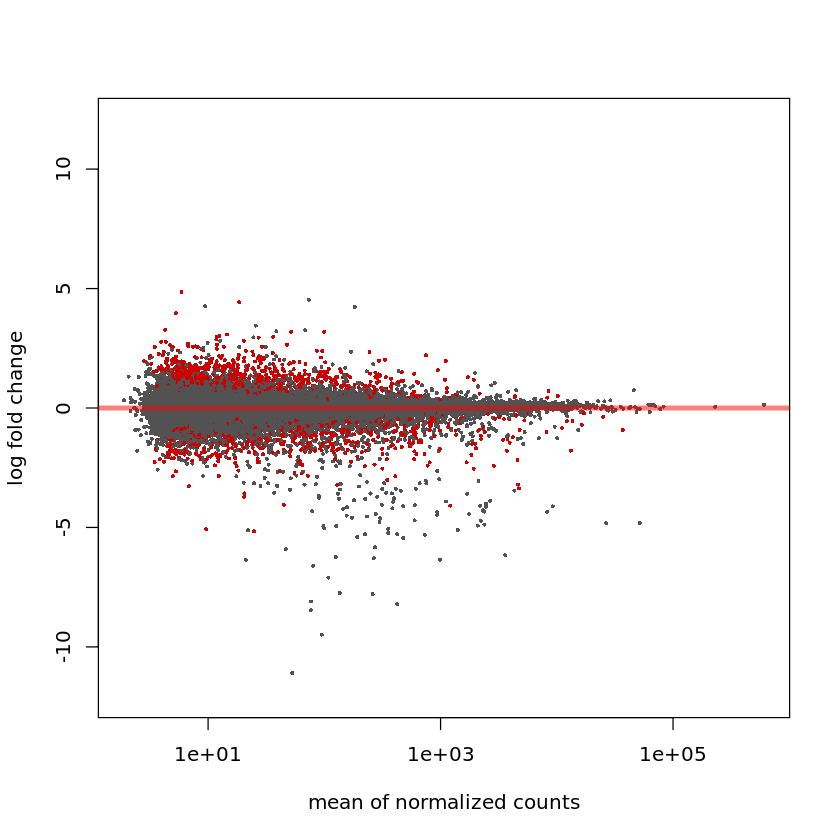

In [57]:
plotMA(res_clean, ylim=c(-12,12))

Save the significant results:

In [58]:
res_clean_sig <- data.frame(subset(res_clean, padj < 0.05))
res_clean_sig <- res_clean_sig[order(res_clean_sig$padj),]
head(res_clean_sig,20)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
TRINITY_DN129162_c0_g1_i1,99.797223,3.1951804,0.34898086,74.49734,6.071996e-18,3.659228e-13
TRINITY_DN153818_c0_g1_i1,52.039184,3.1917884,0.37884570,62.60562,2.525324e-15,7.609306e-11
TRINITY_DN5780_c0_g1_i1,426.743053,-1.3997657,0.16942198,61.44864,4.544434e-15,9.128859e-11
TRINITY_DN10388_c0_g1_i1,40.118769,-1.8457474,0.23776519,53.90238,2.107021e-13,3.174438e-09
TRINITY_DN94593_c0_g1_i1,35.999212,-1.8666718,0.24100865,53.23544,2.958725e-13,3.566092e-09
TRINITY_DN26607_c0_g1_i1,96.201579,2.3928187,0.31341633,52.37647,4.581821e-13,4.601981e-09
TRINITY_DN78527_c0_g1_i1,86.129846,2.3958603,0.32105441,50.80949,1.017807e-12,8.762442e-09
TRINITY_DN112882_c0_g1_i1,13.400765,1.5516474,0.21293703,50.47480,1.207049e-12,9.092699e-09
TRINITY_DN59586_c1_g1_i1,35.915403,2.3152279,0.32320224,48.90308,2.689277e-12,1.800740e-08
TRINITY_DN11200_c0_g1_i2,192.187567,-2.0319906,0.26513672,48.01006,4.240373e-12,2.555418e-08


Now I just want to count how many significant transcripts had LFCs above 2. 

In [59]:
nrow(res_clean_sig[res_clean_sig$log2FoldChange>(2),])
nrow(res_clean_sig[res_clean_sig$log2FoldChange<(-2),])
nrow(res_clean_sig[abs(res_clean_sig$log2FoldChange)>(2),])

[1] 71

[1] 65

[1] 136

In [60]:
head(res_clean_sig)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
TRINITY_DN129162_c0_g1_i1,99.79722,3.195180,0.3489809,74.49734,6.071996e-18,3.659228e-13
TRINITY_DN153818_c0_g1_i1,52.03918,3.191788,0.3788457,62.60562,2.525324e-15,7.609306e-11
TRINITY_DN5780_c0_g1_i1,426.74305,-1.399766,0.1694220,61.44864,4.544434e-15,9.128859e-11
TRINITY_DN10388_c0_g1_i1,40.11877,-1.845747,0.2377652,53.90238,2.107021e-13,3.174438e-09
TRINITY_DN94593_c0_g1_i1,35.99921,-1.866672,0.2410087,53.23544,2.958725e-13,3.566092e-09
TRINITY_DN26607_c0_g1_i1,96.20158,2.392819,0.3134163,52.37647,4.581821e-13,4.601981e-09


Okay 72 significantly above 2 LFC and 62 significantly below -2 LFC. 

Now I'm going to make another PCA, now that the potential contaminants have been removed.

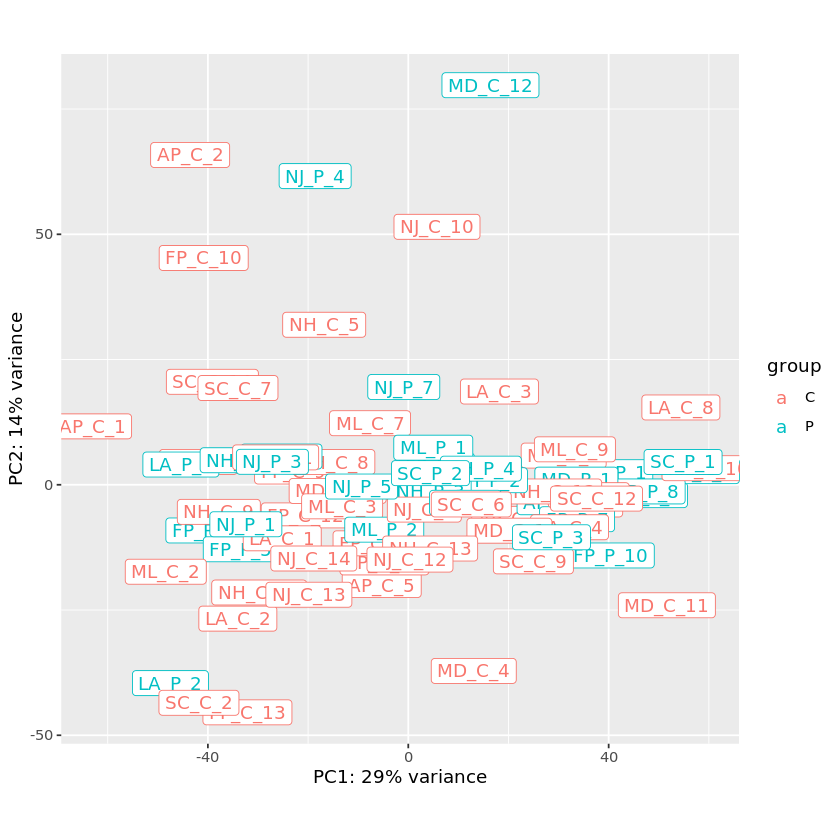

In [61]:
vsd <- vst(dds_clean, blind=FALSE)
PCA <- plotPCA(vsd, intgroup="condition")
PCA + geom_label(aes(label = name))

You can see now that they don't separate out. This is expected, as there is a lot of other variation present in the count data. This does not mean there aren't differences, however, as was shown above in the results summary. 

Let's look at the expression patterns of select transcripts with decapod annotations. 

In [62]:
decapod_annot <- annot[grepl("decapoda",annot[,15]),]

In [63]:
head(res_clean_sig[rownames(res_clean_sig) %in% (decapod_annot[,1]),], 30)
dim(res_clean_sig[(rownames(res_clean_sig) %in% decapod_annot[,1]),])

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
TRINITY_DN129162_c0_g1_i1,99.797223,3.1951804,0.34898086,74.49734,6.071996e-18,3.659228e-13
TRINITY_DN5780_c0_g1_i1,426.743053,-1.3997657,0.16942198,61.44864,4.544434e-15,9.128859e-11
TRINITY_DN94593_c0_g1_i1,35.999212,-1.8666718,0.24100865,53.23544,2.958725e-13,3.566092e-09
TRINITY_DN78527_c0_g1_i1,86.129846,2.3958603,0.32105441,50.80949,1.017807e-12,8.762442e-09
TRINITY_DN4017_c2_g1_i1,156.016123,-1.1223563,0.15935838,46.63060,8.571120e-12,3.810155e-08
TRINITY_DN4300_c0_g2_i2,13653.852892,-0.5447831,0.07977781,45.50873,1.519604e-11,5.723587e-08
TRINITY_DN79806_c0_g1_i1,36.274579,2.9764778,0.40644325,43.42000,4.416505e-11,1.271834e-07
TRINITY_DN9001_c0_g1_i1,1988.597737,-1.4960042,0.21618151,42.60290,6.705981e-11,1.496775e-07
TRINITY_DN394_c0_g1_i2,4585.388840,-2.1786811,0.30555108,40.47224,1.994293e-10,3.534826e-07
TRINITY_DN7584_c1_g1_i1,727.329032,-1.9239069,0.27735838,40.32491,2.150491e-10,3.599922e-07


[1] 269   6

Below I am going to export a selection of counts plots of most significant transcripts, using only those with informative decapod annotations (no hypothetical or unknown proteins). I wrote some simple functions to plot the counts, add annotations manually, and then export a panel type figure using cowplot.

In [64]:
library(cowplot)
easy_plotCounts <- function(ID){
    count_plot <- plotCounts(dds_clean, gene=ID, intgroup=c("condition", "site"), returnData=TRUE)
    ggplot(count_plot, aes(x=condition, y=count, color=site)) +
        theme(strip.text.x = element_text(size = 12), 
        axis.text.x = element_text(size=11), 
        axis.text.y = element_text(size=11)) +
        xlab("") +
        ylab("") +
        geom_point(position=position_jitter(w=0.2,h=0), show.legend = FALSE) + 
        geom_smooth(method = "lm", se=F, aes(group=1), show.legend = FALSE, color = "blue") +
        stat_summary(fun.data=mean_sdl, fun.args = list(mult=1), geom="pointrange", color="red") +
        stat_summary(fun.data=mean_sdl, fun.args = list(mult=1), geom="errorbar", color="red", width=0.2) +
        scale_y_log10()
}

add_title <- function(ID, title){
     easy_plotCounts(ID) + 
        ggtitle(title) + 
        theme(plot.title = element_text(hjust=0.5,size=14,face="bold"), legend.position="none")
}


********************************************************
Note: As of version 1.0.0, cowplot does not change the
  default ggplot2 theme anymore. To recover the previous
  behavior, execute:
  theme_set(theme_cowplot())
********************************************************



In [65]:
rownames(decapod_annot) <- decapod_annot[,1]

In [66]:
options(repr.matrix.max.rows=269, repr.matrix.max.cols=10) #change display options to show entire table
na.omit(decapod_annot[rownames(res_clean_sig),c(3,11,13,14)])
options(repr.matrix.max.rows=50, repr.matrix.max.cols=10)

,Percent.Identical,E.Value,Description,Species
TRINITY_DN129162_c0_g1_i1,54.4,1.7e-45,MPC15748.1 hypothetical protein [Portunus trituberculatus],portunus trituberculatus
TRINITY_DN5780_c0_g1_i1,66.2,2.3e-136,XP_027222165.1 laminin subunit alpha-4-like [Penaeus vannamei],penaeus vannamei
TRINITY_DN94593_c0_g1_i1,52.4,1.5e-28,tr|A0A5B7FU82|A0A5B7FU82_PORTR Endo/exonuclease/phosphatase domain-containing protein OS=Portunus trituberculatus OX=210409 GN=E2C01_043934 PE=4 SV=1,portunus trituberculatus
TRINITY_DN78527_c0_g1_i1,48.9,2.1e-29,UniRef90_A0A5B7CTU7 Uncharacterized protein n=1 [Portunus trituberculatus] TaxID=210409 RepID=A0A5B7CTU7_PORTR,portunus trituberculatus
TRINITY_DN4017_c2_g1_i1,59.6,6.7e-43,XP_027238032.1 cellular retinoic acid-binding protein 1-like [Penaeus vannamei],penaeus vannamei
TRINITY_DN4300_c0_g2_i2,67.0,0.0e+00,ANN13869.1 glycogen debranching enzyme [Macrobrachium nipponense],macrobrachium nipponense
TRINITY_DN79806_c0_g1_i1,34.0,2.0e-14,MPC08067.1 hypothetical protein [Portunus trituberculatus],portunus trituberculatus
TRINITY_DN9001_c0_g1_i1,89.0,0.0e+00,tr|A0A0P4W2M2|A0A0P4W2M2_9EUCA Uncharacterized protein OS=Scylla olivacea OX=85551 PE=4 SV=1,scylla olivacea
TRINITY_DN394_c0_g1_i2,46.6,0.0e+00,tr|A0A0P4WWF6|A0A0P4WWF6_9EUCA Uncharacterized protein OS=Scylla olivacea OX=85551 PE=4 SV=1,scylla olivacea
TRINITY_DN7584_c1_g1_i1,83.5,3.2e-229,tr|A0A0P4W832|A0A0P4W832_9EUCA LRRCT domain-containing protein OS=Scylla olivacea OX=85551 PE=4 SV=1,scylla olivacea


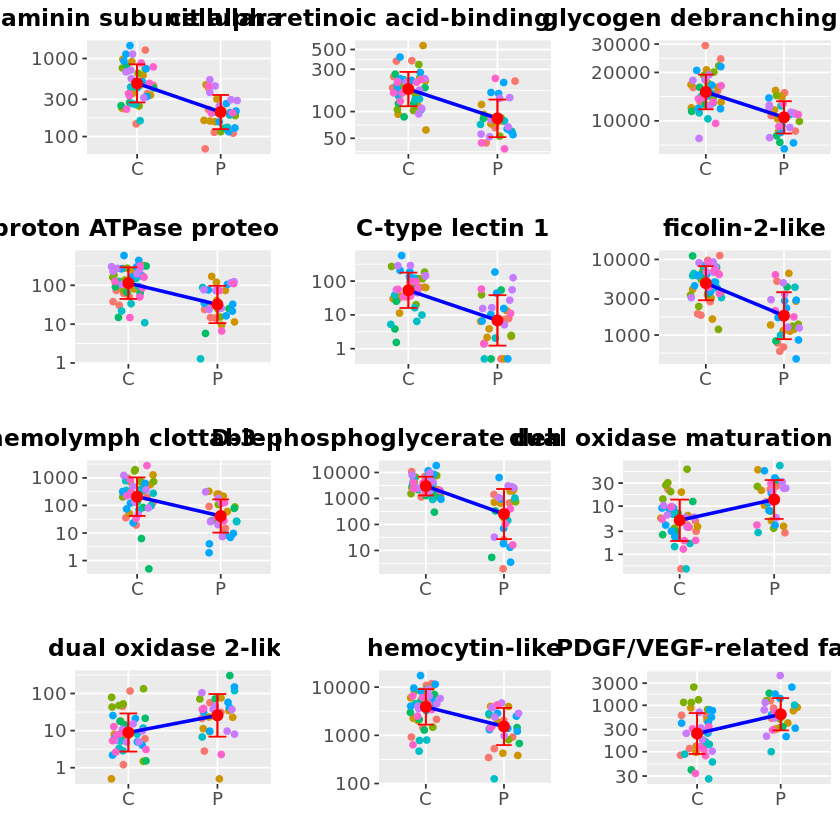

In [67]:
p1 <- add_title("TRINITY_DN5780_c0_g1_i1","laminin subunit alpha-4-like")
p2 <- add_title("TRINITY_DN4017_c2_g1_i1","cellular retinoic acid-binding protein 1-like")
p3 <- add_title("TRINITY_DN4300_c0_g2_i2","glycogen debranching enzyme")
p4 <- add_title("TRINITY_DN93978_c0_g1_i1","V-type proton ATPase proteolipid subunit")
p5 <- add_title("TRINITY_DN20560_c0_g1_i1","C-type lectin 1")
p6 <- add_title("TRINITY_DN2676_c0_g1_i1","ficolin-2-like")
p7 <- add_title("TRINITY_DN4911_c0_g1_i1","hemolymph clottable protein")
p8 <- add_title("TRINITY_DN440_c0_g1_i1","D-3-phosphoglycerate dehydrogenase")
p9 <- add_title("TRINITY_DN34522_c1_g1_i1","dual oxidase maturation factor 1")
p10 <- add_title("TRINITY_DN96090_c0_g1_i1","dual oxidase 2-like")
p11 <- add_title("TRINITY_DN12148_c0_g1_i1","hemocytin-like")
p12 <- add_title("TRINITY_DN448_c0_g1_i6","PDGF/VEGF-related factor 1")


main <- plot_grid(p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12, nrow=4, ncol=3)
##legend <- get_legend(plot1  + guides(color = guide_legend(nrow = 1)) + theme(legend.position = "bottom"))
##done <- plot_grid(main, legend, nrow=4,ncol=3)

main

save_plot("../vis/DESeq2_top_PvC_genes.pdf", plot=main, nrow=4, ncol=3, base_asp=1.41)

Jupyter didn't render this plot well. Check the `vis/` directory for the output. 

Let's explore other counts.

Query.Sequence,Subject.Sequence,Percent.Identical,E.Value,Coverage,Description,Species


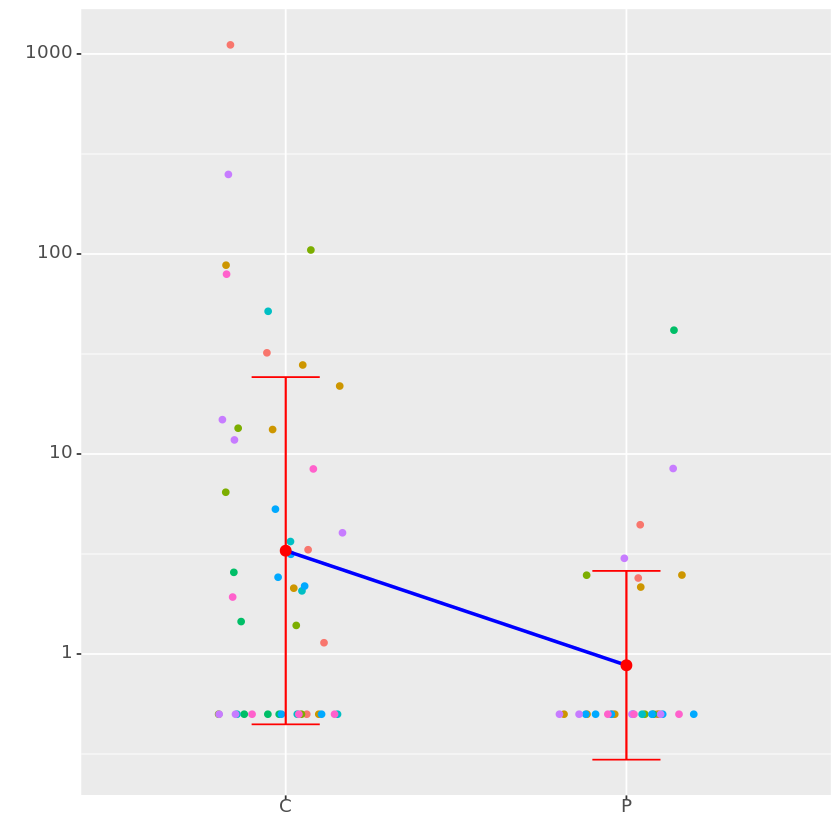

In [68]:
get <- "TRINITY_DN16709_c0_g1_i1"
annot[annot[,1]==get,c(1,2,3,11,12,13,14)]
easy_plotCounts(get)

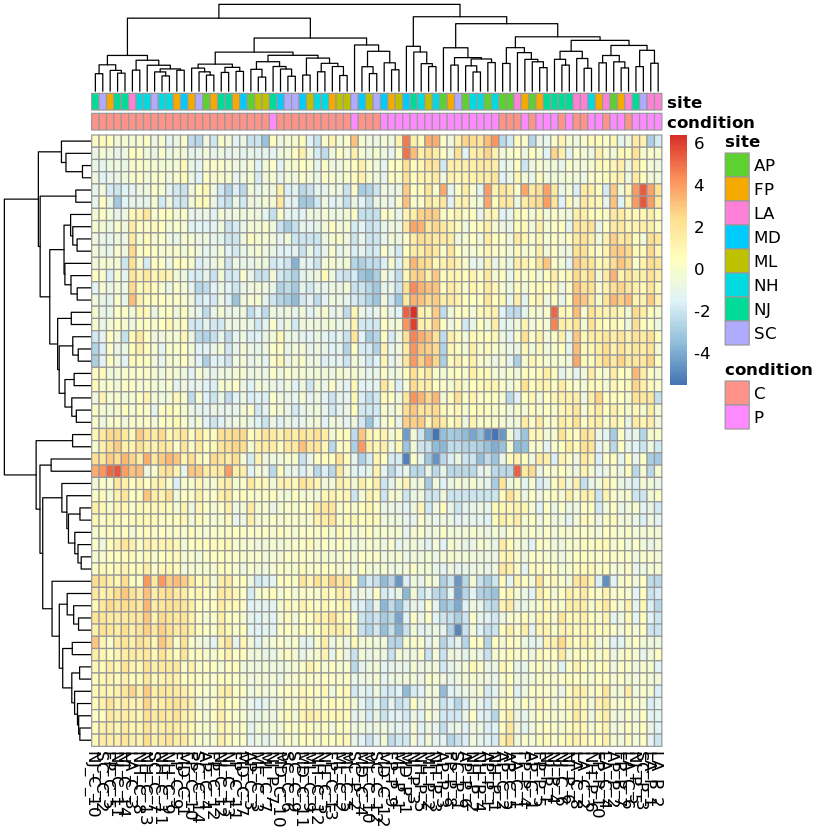

In [188]:
#vsd_df <- assay(vsd)
#vsd_df_diff <- vsd_df - rowMeans(vsd_df)
#pheatmap(vsd_df_diff[rownames(head(res_clean_sig, 50)),], cluster_rows=TRUE, show_rownames=FALSE,
#         cluster_cols=TRUE, annotation_col=df)

## Sex-specific effects

Now we can do a similar test but use a different design in which we add in coefficients for sex and the interaction between sex and condition. We cannot include site in this comparison because there are sites for which there are not parasitized individuals of both sex. 

In [69]:
dds_sex <- DESeqDataSetFromMatrix(countData = counts_clean, colData = coldata, design = ~condition + sex + sex:condition)

factor levels were dropped which had no samples


LRT against reduced model of just sex + condition.

In [70]:
dds_sex <- DESeq(dds_sex, parallel=TRUE, test="LRT", reduced=~condition + sex)

estimating size factors
estimating dispersions
gene-wise dispersion estimates: 34 workers
mean-dispersion relationship
final dispersion estimates, fitting model and testing: 34 workers
-- replacing outliers and refitting for 1451 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


Get results.

In [71]:
res_sex <- results(dds_sex, alpha=0.05)
summary(res_sex)


out of 60488 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 22, 0.036%
LFC < 0 (down)     : 33, 0.055%
outliers [1]       : 0, 0%
low counts [2]     : 16418, 27%
(mean count < 10)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Looks like there are 55 that show a significant interaction.

In [72]:
res_sex_sig <- data.frame(subset(res_sex, padj < 0.05))
res_sex_sig <- res_sex_sig[order(res_sex_sig$padj),]
head(res_sex_sig, 20)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
TRINITY_DN28_c10_g1_i1,9230.24176,-9.438825,1.2266917,38.46652,5.570101e-10,2.454743e-05
TRINITY_DN2290_c0_g1_i1,389.67603,-6.380506,1.0306098,30.39362,3.526862e-08,7.771441e-04
TRINITY_DN28_c0_g1_i2,1223.84299,-11.293815,1.6372957,29.01166,7.194391e-08,1.056856e-03
TRINITY_DN14696_c0_g1_i1,185.71369,-4.352977,0.7850931,26.93284,2.106493e-07,1.553400e-03
TRINITY_DN3753_c0_g1_i1,2190.74282,-10.656431,1.6035841,26.92513,2.114907e-07,1.553400e-03
TRINITY_DN4730_c0_g1_i2,224.50301,-4.086883,0.7306736,27.69587,1.419658e-07,1.553400e-03
TRINITY_DN8359_c0_g1_i1,22.19430,6.001900,1.1125195,26.30114,2.921167e-07,1.595616e-03
TRINITY_DN2959_c0_g1_i1,944.24485,3.764388,0.7243847,26.09006,3.258575e-07,1.595616e-03
TRINITY_DN6370_c0_g1_i4,232.33787,5.148699,0.9717074,26.10000,3.241836e-07,1.595616e-03
TRINITY_DN656_c0_g1_i1,1003.94916,-10.194073,1.6246731,25.30002,4.907028e-07,1.858273e-03


Find those with any annotation

In [73]:
res_sex_sig[rownames(res_sex_sig)%in%annot[,1],]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
TRINITY_DN8359_c0_g1_i1,22.19430,6.001900,1.1125195,26.30114,2.921167e-07,0.001595616
TRINITY_DN6370_c0_g1_i4,232.33787,5.148699,0.9717074,26.10000,3.241836e-07,0.001595616
TRINITY_DN11336_c0_g1_i1,25.85115,5.454516,1.1551123,21.14111,4.266765e-06,0.009872167
TRINITY_DN10668_c0_g1_i1,94.83808,2.857423,0.6292018,20.39081,6.313232e-06,0.011128966
TRINITY_DN22111_c0_g1_i1,329.02045,4.132957,0.9385560,18.53186,1.670875e-05,0.023011082
TRINITY_DN19214_c0_g1_i1,19.16767,4.548966,1.0593150,17.85261,2.386918e-05,0.028430131
TRINITY_DN1343_c0_g1_i1,140.73057,5.595378,1.3040805,17.03067,3.678083e-05,0.036839349
TRINITY_DN93297_c0_g1_i1,156.74382,0.800801,0.1979418,16.42139,5.070981e-05,0.044910512
TRINITY_DN36990_c0_g1_i1,47.80610,2.883860,0.7071570,16.41230,5.095361e-05,0.044910512
TRINITY_DN9764_c0_g1_i1,16.98116,6.888293,1.7245730,16.05639,6.148385e-05,0.049958867


Get select annotations.

In [74]:
annot[annot[,1]=="TRINITY_DN8359_c0_g1_i1",c(1,2,3,11,12,13,14)]

,Query.Sequence,Subject.Sequence,Percent.Identical,E.Value,Coverage,Description,Species
18731,TRINITY_DN8359_c0_g1_i1,XP_018009231.1,34.8,2.6e-81,77.1,XP_018009231.1 PREDICTED: uncharacterized protein LOC108666815 [Hyalella azteca],hyalella azteca


Modify the plotting function from above.

In [75]:
easy_plotCounts_sex <- function(ID){
    count_plot <- plotCounts(dds_sex, gene=ID, intgroup=c("condition", "site", "sex"), returnData=TRUE)
    ggplot(count_plot, aes(x=condition, y=count, color=site)) +
        facet_grid(.~sex) +
        theme(strip.text.x = element_text(size = 12), 
        axis.text.x = element_text(size=11), 
        axis.text.y = element_text(size=11)) +
        xlab("") +
        ylab("") +
        geom_point(position=position_jitter(w=0.2,h=0), show.legend = TRUE) + 
        geom_smooth(method = "lm", se=F, aes(group=1), show.legend = FALSE, color = "blue") +
        stat_summary(fun.data=mean_sdl, fun.args = list(mult=1), geom="pointrange", color="red") +
        stat_summary(fun.data=mean_sdl, fun.args = list(mult=1), geom="errorbar", color="red", width=0.2) +
        scale_y_log10()
}

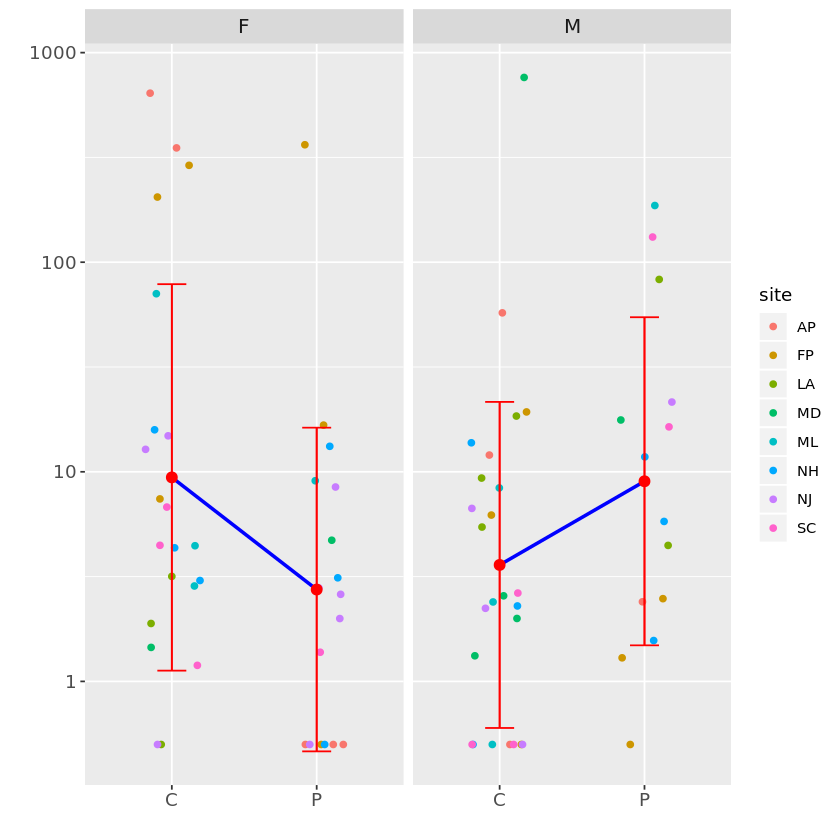

In [76]:
easy_plotCounts_sex("TRINITY_DN8359_c0_g1_i1")

Just checking to see the balance of sex/condition.

In [77]:
nrow(coldata[coldata$sex=="F"&coldata$condition=="P",])
nrow(coldata[coldata$sex=="F"&coldata$condition=="C",])
nrow(coldata[coldata$sex=="M"&coldata$condition=="P",])
nrow(coldata[coldata$sex=="M"&coldata$condition=="C",])

[1] 17

[1] 21

[1] 14

[1] 25

As you can see, the sample sizes are uneven. We'll do the following to account for this when looking for differences between the sexes in the magnitude of their transcriptional response. 

Let's make Wald contrasts just looking at P vs C within each sex. However, because there are unequal sample sizes, we'll subsample to the smallest number of P and C crabs between each sex. We'll do this randomly over 1000 iteractions, in what is kind of like a rarefaction procedure. More like downsampling with randomization. This will take a really long time, so if you are re-running these analysis and would like to skip, just go directly to the next set of analyses.

First we'll add a column to our coldata to pair sex and condition into one term.

In [78]:
coldata_raref <- coldata
coldata_raref$group <- factor(paste0(coldata_raref$sex, coldata_raref$condition))

Next is the loop that runs the analyses 1000 times. The end of this chunk saves the resulting objects, so just skip and load if you've already run. If this is thefirst time running this notebook, uncomment the following code. Note that this will take a really long time.

In [79]:
#sex_raref <- data.frame(rep=integer(0),sex=character(0),up=integer(0),down=integer(0), stringsAsFactors = FALSE) #initialize
#DE_female <- list() #initialize list the will hold names of DE transcripts in each iteration
#DE_male <- list() #again
#for (i in 1:1000){
#    coldata_C <- coldata_raref[coldata_raref$condition == "C",] #subset to just control
#    coldata_C <- coldata_C %>% rownames_to_column('sample') %>% group_by(sex) %>% sample_n(size=21) %>% column_to_rownames('sample') #group by site and randomly sample 21 (lowest number of C samples in either sex (F))
#    coldata_P <- coldata_raref[coldata_raref$condition == "P",] #subset to just parasitized
#    coldata_P <- coldata_P %>% rownames_to_column('sample') %>% group_by(sex) %>% sample_n(size=14) %>% column_to_rownames('sample') #group by site and randomly sample 2 (lowest number of P samples in either sex (M))
#    coldata_iter <- rbind(coldata_C,coldata_P) #combine dfs
#    counts_clean_raref <- counts_clean[,match(rownames(coldata_iter), colnames(counts_clean))] #subset count data to match included samples
#    dds_sex_raref <- DESeqDataSetFromMatrix(countData = counts_clean_raref, colData = coldata_iter, design = ~group)
#    dds_sex_raref <- DESeq(dds_sex_raref, parallel=TRUE, quiet=TRUE)
#    res_FPvFC <- results(dds_sex_raref, contrast=c("group", "FP", "FC"), alpha=0.05)
#    res_MPvMC <- results(dds_sex_raref, contrast=c("group", "MP", "MC"), alpha=0.05)
#    sex_raref <- rbind(sex_raref, list(rep=i,sex="F",up=nrow(res_FPvFC[which(res_FPvFC$log2FoldChange>0 & res_FPvFC$padj<0.05),]),down=nrow(res_FPvFC[which(res_FPvFC$log2FoldChange<0 & res_FPvFC$padj<0.05),])), stringsAsFactors=FALSE) #append rep, sex, and # up and down sig DE transcripts
#    sex_raref <- rbind(sex_raref, list(rep=i,sex="M",up=nrow(res_MPvMC[which(res_MPvMC$log2FoldChange>0 & res_MPvMC$padj<0.05),]),down=nrow(res_MPvMC[which(res_MPvMC$log2FoldChange<0 & res_MPvMC$padj<0.05),])), stringsAsFactors=FALSE) #repeat for male
#    DE_female[[i]] <- c(rownames(res_FPvFC[which(res_FPvFC$padj<0.05),]))
#    DE_male[[i]] <- c(rownames(res_MPvMC[which(res_MPvMC$padj<0.05),]))
#}
#save(sex_raref, DE_female, DE_male, file="sex_raref.RData")

Load in the data (since you did this at some point before).

In [79]:
load("sex_raref.RData")
sex_raref$total <- sex_raref$up + sex_raref$down
sex_raref$sex <- factor(sex_raref$sex)

Get summary stats.

In [80]:
summary(sex_raref[sex_raref$sex=="F",])
summary(sex_raref[sex_raref$sex=="M",])

      rep         sex            up             down           total      
 Min.   :   1.0   F:1000   Min.   : 33.0   Min.   : 93.0   Min.   :143.0  
 1st Qu.: 250.8   M:   0   1st Qu.: 75.0   1st Qu.:150.0   1st Qu.:238.8  
 Median : 500.5            Median :103.0   Median :187.0   Median :299.0  
 Mean   : 500.5            Mean   :119.5   Mean   :206.1   Mean   :325.6  
 3rd Qu.: 750.2            3rd Qu.:145.0   3rd Qu.:243.0   3rd Qu.:392.2  
 Max.   :1000.0            Max.   :401.0   Max.   :620.0   Max.   :777.0  

      rep         sex            up              down            total       
 Min.   :   1.0   F:   0   Min.   : 370.0   Min.   : 322.0   Min.   : 749.0  
 1st Qu.: 250.8   M:1000   1st Qu.: 511.0   1st Qu.: 464.0   1st Qu.: 993.8  
 Median : 500.5            Median : 594.0   Median : 518.5   Median :1107.0  
 Mean   : 500.5            Mean   : 662.7   Mean   : 536.7   Mean   :1199.4  
 3rd Qu.: 750.2            3rd Qu.: 730.0   3rd Qu.: 587.0   3rd Qu.:1290.5  
 Max.   :1000.0            Max.   :2666.0   Max.   :1183.0   Max.   :3805.0  

In [81]:
sex_raref_long <- gather(sex_raref, "up", "down", "total", key="direction", value="number")
sex_raref_long$direction <- factor(sex_raref_long$direction, levels=c("up","down","total"))

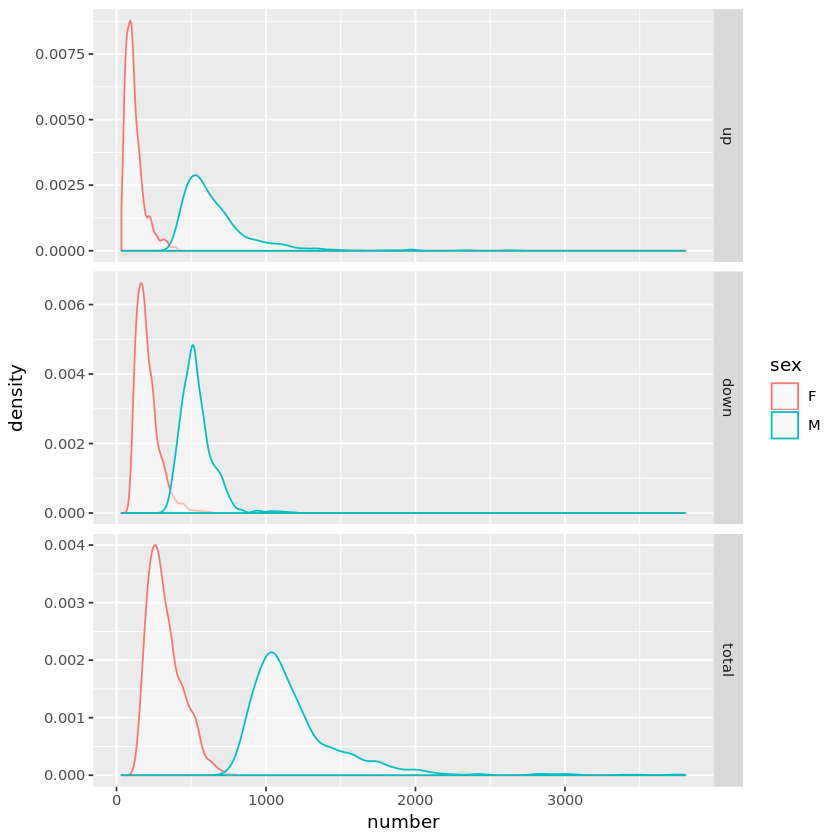

In [82]:
ggplot(sex_raref_long, aes(x=number, color=sex)) +
    geom_density(fill="white", alpha=0.5, position="identity") +
    facet_grid(rows= vars(direction), scales="free")

Let's visualize the same data but as a boxplot.

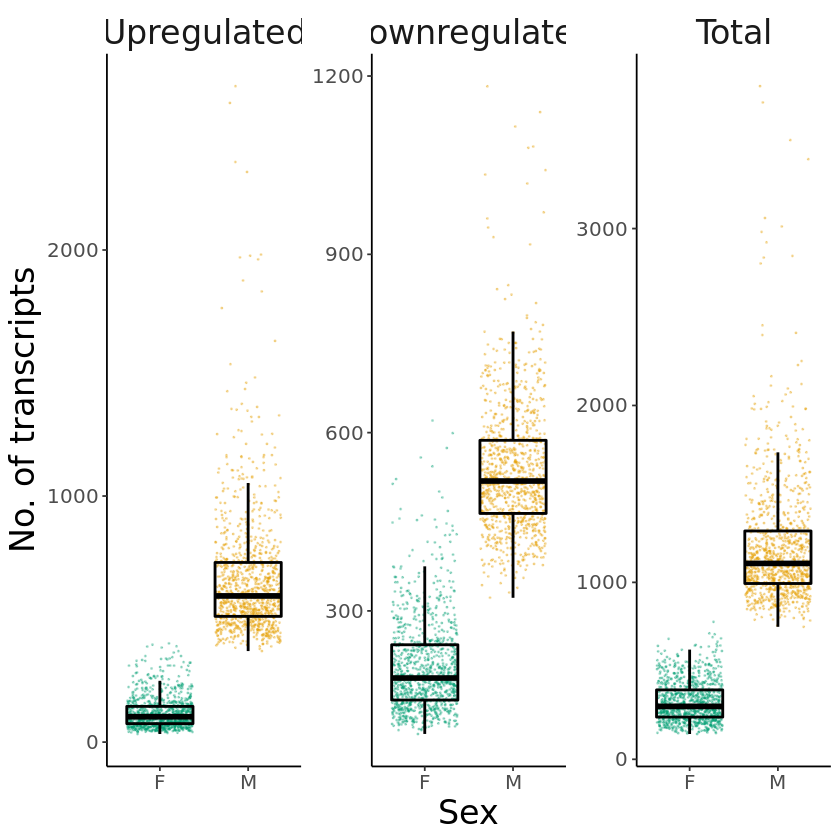

In [125]:
direction.labs <- c("Upregulated", "Downregulated", "Total")
names(direction.labs) <- c("up", "down", "total")
ggplot(sex_raref_long, aes(x=sex, y=number, color=sex)) +
    theme_classic() +
    facet_wrap(.~direction, scales = "free_y", labeller = as_labeller(direction.labs)) +
    geom_jitter(width=0.37, size=0.2, alpha=0.3) +
    geom_boxplot(outlier.shape = NA, lwd=0.8, color="black", alpha=0) +
    labs(x="Sex", y="No. of transcripts") +
    theme(axis.text=element_text(size=12), 
          axis.title=element_text(size=20),
          strip.text.x = element_text(size = 20),
          panel.grid = element_blank(),
          plot.title = element_text(size=20, hjust = 0.5, face="bold"),
          strip.background = element_blank(),
          legend.position = "none") +
    scale_color_manual(values=c("#009E73","#E69F00"))
ggsave("../vis/sex_DE.pdf", height=5, width=12)

I'll do both a t-test and a Mann-Whitney-Wilcoxon test, because the data are not particularly normally distributed, especially for males.

In [91]:
wilcox.test(up ~ sex, data=sex_raref, conf.int=TRUE)
wilcox.test(down ~ sex, data=sex_raref, conf.int=TRUE)
wilcox.test(total ~ sex, data=sex_raref, conf.int=TRUE)
t.test(up ~ sex, data=sex_raref)
t.test(down ~ sex, data=sex_raref)
t.test(total ~ sex, data=sex_raref)


	Wilcoxon rank sum test with continuity correction

data:  up by sex
W = 29, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0
95 percent confidence interval:
 -494.9999 -474.0000
sample estimates:
difference in location 
                  -484 



	Wilcoxon rank sum test with continuity correction

data:  down by sex
W = 8991, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0
95 percent confidence interval:
 -333 -319
sample estimates:
difference in location 
                  -326 



	Wilcoxon rank sum test with continuity correction

data:  total by sex
W = 2, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0
95 percent confidence interval:
 -815 -786
sample estimates:
difference in location 
                  -800 



	Welch Two Sample t-test

data:  up by sex
t = -65.857, df = 1128.9, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -559.3845 -527.0175
sample estimates:
mean in group F mean in group M 
        119.523         662.724 



	Welch Two Sample t-test

data:  down by sex
t = -77.781, df = 1811.9, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -338.9105 -322.2395
sample estimates:
mean in group F mean in group M 
        206.107         536.682 



	Welch Two Sample t-test

data:  total by sex
t = -76.022, df = 1214.8, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -896.3256 -851.2264
sample estimates:
mean in group F mean in group M 
        325.630        1199.406 


Regardless of the test, the difference is extremely significant for all groups (up, down, total).

## Range-specific effects

Now that we have looked for bulk differences as a result of infection status, and how it interacts with sex, we can move on to look at differences among populations with different levels of historical exposure to the parasite. We included the FP samples in our first comparison because it was agnostic to range. However, because it is unresolved whether Loxo is native, invasive, or absent in FP, we are going to remove it from subsequent analyses. Also, we are going to remove the MD samples as well. Three reasons. First, the Loxo used to infect the crabs during the experiment were from MD. It is plausible that these Loxo could be locally adapted to the MD hosts, or vice versa, and that this site-level signal could interfere with the more regional perspective. Second, in the population genomic study of Rhithro, MD clustered with the Northeastern sites where the parasite is absent (NJ, MA, NH). This shared deeper evolutionary history may interfere with questions about more recent adaptations to the presence of the parasite. And third, after removal of FP, both the native and absent ranges have two sites each and thus fewer samples. Exclusion of MD will make sample sizes more even. 

We have to make another dds object. I am going to make it from scratch by removing all FP and MD samples from the coldata and counts_clean.

In [92]:
colnames(counts_clean)

[1] "AP_C_1"  "AP_C_2"  "AP_C_3"  "AP_C_4"  "AP_C_5"  "AP_P_1"  "AP_P_2" 
 [8] "AP_P_3"  "AP_P_6"  "FP_C_10" "FP_C_11" "FP_C_12" "FP_C_13" "FP_C_5" 
[15] "FP_C_9"  "FP_P_10" "FP_P_4"  "FP_P_5"  "FP_P_7"  "FP_P_8"  "FP_P_9" 
[22] "LA_C_1"  "LA_C_2"  "LA_C_3"  "LA_C_4"  "LA_C_6"  "LA_C_8"  "LA_P_1" 
[29] "LA_P_2"  "MD_C_10" "MD_C_11" "MD_C_12" "MD_C_1"  "MD_C_4"  "MD_C_7" 
[36] "MD_P_1"  "ML_C_10" "ML_C_2"  "ML_C_3"  "ML_C_5"  "ML_C_7"  "ML_C_9" 
[43] "ML_P_1"  "ML_P_2"  "NH_C_11" "NH_C_12" "NH_C_13" "NH_C_5"  "NH_C_8" 
[50] "NH_C_9"  "NH_P_1"  "NH_P_2"  "NH_P_3"  "NH_P_4"  "NH_P_5"  "NH_P_6" 
[57] "NJ_C_10" "NJ_C_11" "NJ_C_12" "NJ_C_13" "NJ_C_14" "NJ_C_6"  "NJ_P_1" 
[64] "NJ_P_3"  "NJ_P_4"  "NJ_P_5"  "NJ_P_6"  "NJ_P_7"  "SC_C_12" "SC_C_14"
[71] "SC_C_2"  "SC_C_6"  "SC_C_7"  "SC_C_9"  "SC_P_1"  "SC_P_2"  "SC_P_3"

In [93]:
counts_clean_noFPMD <- counts_clean[,!grepl("FP_*",colnames(counts_clean))]
counts_clean_noFPMD <- counts_clean_noFPMD[,!grepl("MD_*",colnames(counts_clean_noFPMD))]
coldata_noFPMD <- coldata[colnames(counts_clean_noFPMD),]

Let's just check to make sure they were removed.

In [94]:
dim(counts_clean_noFPMD)

[1] 60488    58

Just a quick sanity check to make sure the samples are in the same order in the counts and metadata matrices.

In [95]:
all(rownames(coldata_noFPMD) == colnames(counts_clean_noFPMD))

[1] TRUE

In [96]:
rownames(coldata_noFPMD)

[1] "AP_C_1"  "AP_C_2"  "AP_C_3"  "AP_C_4"  "AP_C_5"  "AP_P_1"  "AP_P_2" 
 [8] "AP_P_3"  "AP_P_6"  "LA_C_1"  "LA_C_2"  "LA_C_3"  "LA_C_4"  "LA_C_6" 
[15] "LA_C_8"  "LA_P_1"  "LA_P_2"  "ML_C_10" "ML_C_2"  "ML_C_3"  "ML_C_5" 
[22] "ML_C_7"  "ML_C_9"  "ML_P_1"  "ML_P_2"  "NH_C_11" "NH_C_12" "NH_C_13"
[29] "NH_C_5"  "NH_C_8"  "NH_C_9"  "NH_P_1"  "NH_P_2"  "NH_P_3"  "NH_P_4" 
[36] "NH_P_5"  "NH_P_6"  "NJ_C_10" "NJ_C_11" "NJ_C_12" "NJ_C_13" "NJ_C_14"
[43] "NJ_C_6"  "NJ_P_1"  "NJ_P_3"  "NJ_P_4"  "NJ_P_5"  "NJ_P_6"  "NJ_P_7" 
[50] "SC_C_12" "SC_C_14" "SC_C_2"  "SC_C_6"  "SC_C_7"  "SC_C_9"  "SC_P_1" 
[57] "SC_P_2"  "SC_P_3"

Because we have removed the FP and MD samples, I am going to re-normalize the counts and do a second round of expression filtering, using the same process of removing transcripts that have normalized counts less than 10 in over 90% of samples (52 in this case). 

In [97]:
dds <- DESeqDataSetFromMatrix(countData = counts_clean_noFPMD, colData = coldata_noFPMD, design = ~ condition)
dds <- estimateSizeFactors(dds)
norm_mat <- counts(dds, normalized=TRUE)
dim(norm_mat)
remove <- rowSums(norm_mat < 10 ) > 52
norm_mat <- norm_mat[!remove,]
dim(norm_mat)
counts_clean_noFPMD <- counts_clean_noFPMD[rownames(norm_mat),]

factor levels were dropped which had no samples


[1] 60488    58

[1] 59579    58

Okay now we're working with 59579 transcripts.

### Comparing infected vs control within ranges, controlling for site

With this pared down dataset, we'll do two different analyses. The first will be just looking at the difference between infected and control *within* each range. This allows us to control for site-specific effects within the ranges. We'll do the same procedure as for the within sex comparison. But first...

There is an added complication when correcting for individual effects that are nested within groups. I am implementing an approach outlined in the ["Group-specific condition effects, individuals nested within groups"](http://bioconductor.org/packages/devel/bioc/vignettes/DESeq2/inst/doc/DESeq2.html#group-specific-condition-effects-individuals-nested-within-groups) section of the DESeq2 vignette. Essentially we just assign a unique identifier to each site by range.

In [98]:
print(coldata_noFPMD)

        site condition    range sex
AP_C_1    AP         C   Native   F
AP_C_2    AP         C   Native   F
AP_C_3    AP         C   Native   M
AP_C_4    AP         C   Native   M
AP_C_5    AP         C   Native   M
AP_P_1    AP         P   Native   F
AP_P_2    AP         P   Native   F
AP_P_3    AP         P   Native   F
AP_P_6    AP         P   Native   M
LA_C_1    LA         C   Native   M
LA_C_2    LA         C   Native   M
LA_C_3    LA         C   Native   F
LA_C_4    LA         C   Native   M
LA_C_6    LA         C   Native   F
LA_C_8    LA         C   Native   F
LA_P_1    LA         P   Native   M
LA_P_2    LA         P   Native   M
ML_C_10   ML         C Invasive   M
ML_C_2    ML         C Invasive   M
ML_C_3    ML         C Invasive   F
ML_C_5    ML         C Invasive   M
ML_C_7    ML         C Invasive   F
ML_C_9    ML         C Invasive   F
ML_P_1    ML         P Invasive   F
ML_P_2    ML         P Invasive   M
NH_C_11   NH         C   Absent   M
NH_C_12   NH         C   Abs

We have to add a column assigning unique factors to each population *within* each range. We are going to add a column with the following values:

In [99]:
coldata_noFPMD$site.n <- factor(c(1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2))
print(coldata_noFPMD)

        site condition    range sex site.n
AP_C_1    AP         C   Native   F      1
AP_C_2    AP         C   Native   F      1
AP_C_3    AP         C   Native   M      1
AP_C_4    AP         C   Native   M      1
AP_C_5    AP         C   Native   M      1
AP_P_1    AP         P   Native   F      1
AP_P_2    AP         P   Native   F      1
AP_P_3    AP         P   Native   F      1
AP_P_6    AP         P   Native   M      1
LA_C_1    LA         C   Native   M      2
LA_C_2    LA         C   Native   M      2
LA_C_3    LA         C   Native   F      2
LA_C_4    LA         C   Native   M      2
LA_C_6    LA         C   Native   F      2
LA_C_8    LA         C   Native   F      2
LA_P_1    LA         P   Native   M      2
LA_P_2    LA         P   Native   M      2
ML_C_10   ML         C Invasive   M      1
ML_C_2    ML         C Invasive   M      1
ML_C_3    ML         C Invasive   F      1
ML_C_5    ML         C Invasive   M      1
ML_C_7    ML         C Invasive   F      1
ML_C_9    M

You can see now that each site has a unique number in relation to other sites in its range. They are repeated across ranges, but it doesn't matter because we are interested in looking at effects of infection within sites. 

Now I'm just going to check the factor levels.

In [100]:
coldata_noFPMD$sex
coldata_noFPMD$condition
coldata_noFPMD$range
coldata_noFPMD$site

[1] F F M M M F F F M M M F M F F M M M M F M F F F M M M M F F F M M M F F F F
[39] F M M M F M F F F F F M F M F F M F M M
Levels: F M

[1] C C C C C P P P P C C C C C C P P C C C C C C P P C C C C C C P P P P P P C
[39] C C C C C P P P P P P C C C C C C P P P
Levels: C F P

[1] Native   Native   Native   Native   Native   Native   Native   Native  
 [9] Native   Native   Native   Native   Native   Native   Native   Native  
[17] Native   Invasive Invasive Invasive Invasive Invasive Invasive Invasive
[25] Invasive Absent   Absent   Absent   Absent   Absent   Absent   Absent  
[33] Absent   Absent   Absent   Absent   Absent   Absent   Absent   Absent  
[41] Absent   Absent   Absent   Absent   Absent   Absent   Absent   Absent  
[49] Absent   Invasive Invasive Invasive Invasive Invasive Invasive Invasive
[57] Invasive Invasive
Levels: Native Invasive Absent

[1] AP AP AP AP AP AP AP AP AP LA LA LA LA LA LA LA LA ML ML ML ML ML ML ML ML
[26] NH NH NH NH NH NH NH NH NH NH NH NH NJ NJ NJ NJ NJ NJ NJ NJ NJ NJ NJ NJ SC
[51] SC SC SC SC SC SC SC SC
Levels: AP FP LA MA MD ML NH NJ para SC

Looks like the condition column retained the old value "F" for the loxo externae and the site column retained the old value "para". Let's also get rid of the sites we removed. Let's relevel.

In [101]:
coldata_noFPMD$condition <- factor(coldata_noFPMD$condition, c("C","P"))
coldata_noFPMD$site <- factor(coldata_noFPMD$site, c('AP','LA','ML','NH','NJ','SC'))
coldata_noFPMD$condition
coldata_noFPMD$site

[1] C C C C C P P P P C C C C C C P P C C C C C C P P C C C C C C P P P P P P C
[39] C C C C C P P P P P P C C C C C C P P P
Levels: C P

[1] AP AP AP AP AP AP AP AP AP LA LA LA LA LA LA LA LA ML ML ML ML ML ML ML ML
[26] NH NH NH NH NH NH NH NH NH NH NH NH NJ NJ NJ NJ NJ NJ NJ NJ NJ NJ NJ NJ SC
[51] SC SC SC SC SC SC SC SC
Levels: AP LA ML NH NJ SC

Now we can make a model matrix that includes the terms we want to use in our forumlae.

In [102]:
mm <- model.matrix(~ range + range:site.n + range:condition, coldata_noFPMD)
head(mm)

,(Intercept),rangeInvasive,rangeAbsent,rangeNative:site.n2,rangeInvasive:site.n2,rangeAbsent:site.n2,rangeNative:conditionP,rangeInvasive:conditionP,rangeAbsent:conditionP
AP_C_1,1,0,0,0,0,0,0,0,0
AP_C_2,1,0,0,0,0,0,0,0,0
AP_C_3,1,0,0,0,0,0,0,0,0
AP_C_4,1,0,0,0,0,0,0,0,0
AP_C_5,1,0,0,0,0,0,0,0,0
AP_P_1,1,0,0,0,0,0,1,0,0


In [103]:
colnames(mm)

[1] "(Intercept)"              "rangeInvasive"           
[3] "rangeAbsent"              "rangeNative:site.n2"     
[5] "rangeInvasive:site.n2"    "rangeAbsent:site.n2"     
[7] "rangeNative:conditionP"   "rangeInvasive:conditionP"
[9] "rangeAbsent:conditionP"

Let's take a look at the full model matrix.

In [104]:
print(unname(mm))

      [,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8] [,9]
 [1,]    1    0    0    0    0    0    0    0    0
 [2,]    1    0    0    0    0    0    0    0    0
 [3,]    1    0    0    0    0    0    0    0    0
 [4,]    1    0    0    0    0    0    0    0    0
 [5,]    1    0    0    0    0    0    0    0    0
 [6,]    1    0    0    0    0    0    1    0    0
 [7,]    1    0    0    0    0    0    1    0    0
 [8,]    1    0    0    0    0    0    1    0    0
 [9,]    1    0    0    0    0    0    1    0    0
[10,]    1    0    0    1    0    0    0    0    0
[11,]    1    0    0    1    0    0    0    0    0
[12,]    1    0    0    1    0    0    0    0    0
[13,]    1    0    0    1    0    0    0    0    0
[14,]    1    0    0    1    0    0    0    0    0
[15,]    1    0    0    1    0    0    0    0    0
[16,]    1    0    0    1    0    0    1    0    0
[17,]    1    0    0    1    0    0    1    0    0
[18,]    1    1    0    0    0    0    0    0    0
[19,]    1    1    0    0    0 

In [105]:
colnames(mm)

[1] "(Intercept)"              "rangeInvasive"           
[3] "rangeAbsent"              "rangeNative:site.n2"     
[5] "rangeInvasive:site.n2"    "rangeAbsent:site.n2"     
[7] "rangeNative:conditionP"   "rangeInvasive:conditionP"
[9] "rangeAbsent:conditionP"

Okay now we are going to do the same randomization procedure as we did for the between sex comparison, except we are goind to do 5000 iterations. We are downsampling to 2 for parasitized and 5 for control. Uncomment if this is the first time running. Again, this will take a very long time, depending on your resources. 

In [ ]:
#range_raref <- data.frame(rep=integer(0),range=character(0),up=integer(0),down=integer(0), stringsAsFactors = FALSE)
#DE_native <- list() 
#DE_invasive <- list()
#DE_absent <- list()
#for (i in 1:5000){
#    coldata_noFPMD_C <- coldata_noFPMD[coldata_noFPMD$condition == "C",] #subset to just control
#    coldata_noFPMD_C <- coldata_noFPMD_C %>% rownames_to_column('sample') %>% group_by(site) %>% sample_n(size=5) %>% column_to_rownames('sample') #group by site and randomly sample 5 (lowest number of C samples in any site)
#    coldata_noFPMD_P <- coldata_noFPMD[coldata_noFPMD$condition == "P",] #subset to just parasitized
#    coldata_noFPMD_P <- coldata_noFPMD_P %>% rownames_to_column('sample') %>% group_by(site) %>% sample_n(size=2) %>% column_to_rownames('sample') #group by site and randomly sample 2 (lowest number of P samples in any site)
#    coldata_noFPMD_raref <- rbind(coldata_noFPMD_C,coldata_noFPMD_P) #combine dfs
#    add_C <- coldata_noFPMD[intersect(rownames(coldata_noFPMD[coldata_noFPMD$condition=="C",]), setdiff(rownames(coldata_noFPMD),rownames(coldata_noFPMD_raref))),] %>% rownames_to_column('sample') %>% group_by(range) %>% sample_n(size=1) %>% column_to_rownames('sample') #randomly select one control sample per range from set of samples not already included 
#    coldata_noFPMD_raref <- rbind(coldata_noFPMD_raref, add_C) #add to df
#    add_P <- coldata_noFPMD[intersect(rownames(coldata_noFPMD[coldata_noFPMD$condition=="P",]), setdiff(rownames(coldata_noFPMD),rownames(coldata_noFPMD_raref))),] %>% rownames_to_column('sample') %>% group_by(range) %>% sample_n(size=1) %>% column_to_rownames('sample') #randomly select one parasitized sample per range from set of samples not already included 
#    coldata_noFPMD_raref <- rbind(coldata_noFPMD_raref, add_P) #add to df
#    counts_clean_noFPMD_raref <- counts_clean_noFPMD[,match(rownames(coldata_noFPMD_raref), colnames(counts_clean_noFPMD))] #subset count data to match included samples
#    mm_raref <-  mm[match(rownames(coldata_noFPMD_raref),rownames(mm)),] #subset model matrix
#    dds_range_raref <- DESeqDataSetFromMatrix(countData = counts_clean_noFPMD_raref, colData = coldata_noFPMD_raref, design = mm_raref)
#    dds_range_raref <- DESeq(dds_range_raref, parallel=TRUE, quiet=TRUE)
#    native.PvC <- results(dds_range_raref, alpha=0.05, parallel=TRUE, name="rangeNative.conditionP")
#    invasive.PvC <- results(dds_range_raref, alpha=0.05, parallel=TRUE, name="rangeInvasive.conditionP")
#    absent.PvC <- results(dds_range_raref, alpha=0.05, parallel=TRUE, name="rangeAbsent.conditionP")
#    range_raref <- rbind(range_raref, list(rep=i,range="native",up=nrow(native.PvC[which(native.PvC$log2FoldChange>0 & native.PvC$padj<0.05),]),down=nrow(native.PvC[which(native.PvC$log2FoldChange<0 & native.PvC$padj<0.05),])), stringsAsFactors=FALSE) #append rep, range, and # up and down sig DE transcripts
#    range_raref <- rbind(range_raref, list(rep=i,range="invasive",up=nrow(invasive.PvC[which(invasive.PvC$log2FoldChange>0 & invasive.PvC$padj<0.05),]),down=nrow(invasive.PvC[which(invasive.PvC$log2FoldChange<0 & invasive.PvC$padj<0.05),])), stringsAsFactors=FALSE) #repeat for invasive
#    range_raref <- rbind(range_raref, list(rep=i,range="absent",up=nrow(absent.PvC[which(absent.PvC$log2FoldChange>0 & absent.PvC$padj<0.05),]),down=nrow(absent.PvC[which(absent.PvC$log2FoldChange<0 & absent.PvC$padj<0.05),])), stringsAsFactors=FALSE) #repeat for absent
#    DE_native[[i]] <- c(rownames(native.PvC[which(native.PvC$padj<0.05),]))
#    DE_invasive[[i]] <- c(rownames(invasive.PvC[which(invasive.PvC$padj<0.05),]))
#    DE_absent[[i]] <- c(rownames(absent.PvC[which(absent.PvC$padj<0.05),]))
#}
#save(range_raref, DE_native, DE_invasive, DE_absent, file='range_raref.RData')

In [106]:
load("range_raref.RData")
range_raref$total <- range_raref$up + range_raref$down
range_raref$range <- factor(range_raref$range, levels = c("native","invasive","absent"))

In [107]:
head(range_raref)
dim(range_raref)

rep,range,up,down,total
1,native,26,79,105
1,invasive,1023,603,1626
1,absent,1613,864,2477
2,native,195,169,364
2,invasive,872,397,1269
2,absent,688,73,761


[1] 15000     5

In [108]:
summary(range_raref[range_raref$range=="native",])
summary(range_raref[range_raref$range=="invasive",])
summary(range_raref[range_raref$range=="absent",])

      rep            range            up             down           total      
 Min.   :   1   native  :5000   Min.   : 21.0   Min.   : 61.0   Min.   : 85.0  
 1st Qu.:1251   invasive:   0   1st Qu.: 37.0   1st Qu.: 99.0   1st Qu.:133.0  
 Median :2500   absent  :   0   Median : 61.0   Median :146.0   Median :205.0  
 Mean   :2500                   Mean   :128.1   Mean   :172.5   Mean   :300.6  
 3rd Qu.:3750                   3rd Qu.:202.0   3rd Qu.:246.0   3rd Qu.:449.0  
 Max.   :5000                   Max.   :549.0   Max.   :368.0   Max.   :908.0  

      rep            range            up              down           total     
 Min.   :   1   native  :   0   Min.   : 486.0   Min.   :197.0   Min.   : 726  
 1st Qu.:1251   invasive:5000   1st Qu.: 690.0   1st Qu.:342.0   1st Qu.:1052  
 Median :2500   absent  :   0   Median : 799.0   Median :398.0   Median :1202  
 Mean   :2500                   Mean   : 805.3   Mean   :407.2   Mean   :1213  
 3rd Qu.:3750                   3rd Qu.: 897.0   3rd Qu.:461.0   3rd Qu.:1361  
 Max.   :5000                   Max.   :1378.0   Max.   :832.0   Max.   :1967  

      rep            range            up               down       
 Min.   :   1   native  :   0   Min.   :   14.0   Min.   :   3.0  
 1st Qu.:1251   invasive:   0   1st Qu.:  265.0   1st Qu.: 130.0  
 Median :2500   absent  :5000   Median :  684.5   Median : 285.0  
 Mean   :2500                   Mean   : 1074.0   Mean   : 410.3  
 3rd Qu.:3750                   3rd Qu.: 1495.2   3rd Qu.: 522.0  
 Max.   :5000                   Max.   :10372.0   Max.   :5081.0  
     total        
 Min.   :   21.0  
 1st Qu.:  430.8  
 Median :  973.5  
 Mean   : 1484.3  
 3rd Qu.: 1989.2  
 Max.   :14467.0  

In [109]:
range_raref_long <- gather(range_raref, "up", "down", "total", key="direction", value="number")
range_raref_long$direction <- factor(range_raref_long$direction, levels=c("up","down","total"))

Warning message:
“Removed 1405 rows containing non-finite values (stat_density).”

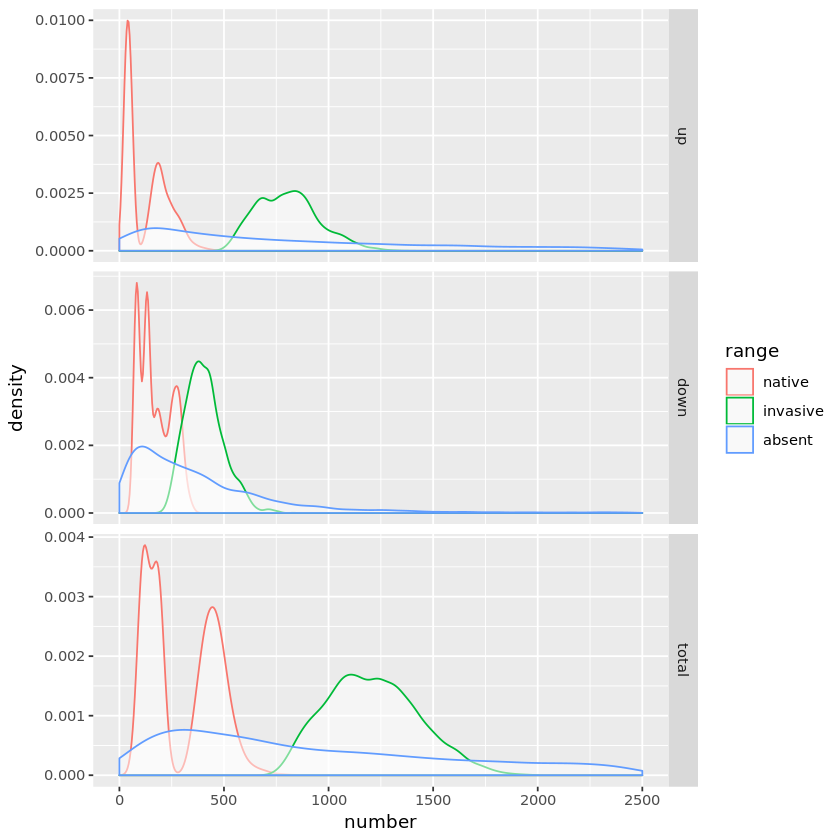

In [110]:
ggplot(range_raref_long, aes(x=number, color=range)) +
    geom_density(fill="white", alpha=0.5, position="identity") +
    facet_grid(rows= vars(direction), scales="free") +
    xlim(c(0,2500))

Warning message:
“Removed 482 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 482 rows containing missing values (geom_point).”Warning message:
“Removed 482 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 482 rows containing missing values (geom_point).”

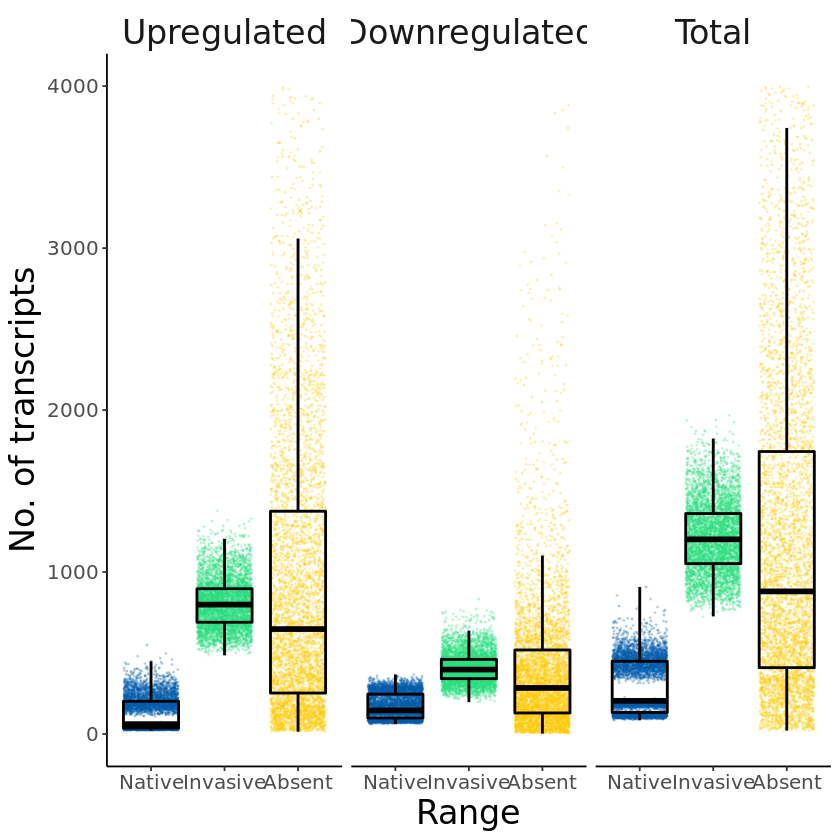

In [127]:
ggplot(range_raref_long, aes(x=range, y=number, color=range)) +
    theme_classic() +
    facet_wrap(.~direction, labeller = as_labeller(direction.labs)) +
    geom_jitter(width=0.37, size=0.2, alpha=0.2) +
    geom_boxplot(outlier.shape = NA, lwd=0.8, color="black", alpha=0) +
    ylim(c(0,4000)) +
    labs(x="Range", y="No. of transcripts") +
    scale_x_discrete(labels = c("native" = "Native", "invasive" = "Invasive", "absent" = "Absent")) +
    theme(axis.text=element_text(size=12), 
          axis.title=element_text(size=20),
          strip.text.x = element_text(size = 20),
          panel.grid = element_blank(),
          plot.title = element_text(size=20, hjust = 0.5, face="bold"),
          strip.background = element_blank(),
          legend.position = "none") +
    scale_color_manual(values=c("#005AAA","#28DC81","#FFCC00"))
ggsave("../vis/range_DE.pdf", height=5, width=12)

In [146]:
kruskal.test(up ~ range, data=range_raref)
kruskal.test(down ~ range, data=range_raref)
kruskal.test(total ~ range, data=range_raref)
wilcox.test(up ~ range, data=range_raref[range_raref$range %in% c("absent","invasive"),])
wilcox.test(up ~ range, data=range_raref[range_raref$range %in% c("native","invasive"),])
wilcox.test(up ~ range, data=range_raref[range_raref$range %in% c("absent","native"),])
wilcox.test(down ~ range, data=range_raref[range_raref$range %in% c("absent","invasive"),])
wilcox.test(down ~ range, data=range_raref[range_raref$range %in% c("native","invasive"),])
wilcox.test(down ~ range, data=range_raref[range_raref$range %in% c("absent","native"),])
wilcox.test(total ~ range, data=range_raref[range_raref$range %in% c("absent","invasive"),])
wilcox.test(total ~ range, data=range_raref[range_raref$range %in% c("native","invasive"),])
wilcox.test(total ~ range, data=range_raref[range_raref$range %in% c("absent","native"),])
t.test(up ~ range, data=range_raref[range_raref$range %in% c("absent","invasive"),])
t.test(up ~ range, data=range_raref[range_raref$range %in% c("native","invasive"),])
t.test(up ~ range, data=range_raref[range_raref$range %in% c("absent","native"),])
t.test(down ~ range, data=range_raref[range_raref$range %in% c("absent","invasive"),])
t.test(down ~ range, data=range_raref[range_raref$range %in% c("native","invasive"),])
t.test(down ~ range, data=range_raref[range_raref$range %in% c("absent","native"),])
t.test(total ~ range, data=range_raref[range_raref$range %in% c("absent","invasive"),])
t.test(total ~ range, data=range_raref[range_raref$range %in% c("native","invasive"),])
t.test(total ~ range, data=range_raref[range_raref$range %in% c("absent","native"),])



	Kruskal-Wallis rank sum test

data:  up by range
Kruskal-Wallis chi-squared = 7949.9, df = 2, p-value < 2.2e-16



	Kruskal-Wallis rank sum test

data:  down by range
Kruskal-Wallis chi-squared = 5542.3, df = 2, p-value < 2.2e-16



	Kruskal-Wallis rank sum test

data:  total by range
Kruskal-Wallis chi-squared = 7281.8, df = 2, p-value < 2.2e-16



	Wilcoxon rank sum test with continuity correction

data:  up by range
W = 13694539, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum test with continuity correction

data:  up by range
W = 87.5, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum test with continuity correction

data:  up by range
W = 2920500, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum test with continuity correction

data:  down by range
W = 15973736, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum test with continuity correction

data:  down by range
W = 473974, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum test with continuity correction

data:  down by range
W = 7852641, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum test with continuity correction

data:  total by range
W = 14308755, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum test with continuity correction

data:  total by range
W = 763.5, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum test with continuity correction

data:  total by range
W = 4140570, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0



	Welch Two Sample t-test

data:  up by range
t = -15.848, df = 5154.6, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -301.9069 -235.4351
sample estimates:
mean in group invasive   mean in group absent 
              805.3398              1074.0108 



	Welch Two Sample t-test

data:  up by range
t = -268.98, df = 8680.1, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -682.1677 -672.2967
sample estimates:
  mean in group native mean in group invasive 
              128.1076               805.3398 



	Welch Two Sample t-test

data:  up by range
t = -56.036, df = 5067.3, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -978.9961 -912.8103
sample estimates:
mean in group native mean in group absent 
            128.1076            1074.0108 



	Welch Two Sample t-test

data:  down by range
t = -0.46711, df = 5384.2, p-value = 0.6404
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -16.26725  10.00685
sample estimates:
mean in group invasive   mean in group absent 
              407.1992               410.3294 



	Welch Two Sample t-test

data:  down by range
t = -138.77, df = 9729.5, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -238.0472 -231.4156
sample estimates:
  mean in group native mean in group invasive 
              172.4678               407.1992 



	Welch Two Sample t-test

data:  down by range
t = -35.685, df = 5274.7, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -250.9290 -224.7942
sample estimates:
mean in group native mean in group absent 
            172.4678             410.3294 



	Welch Two Sample t-test

data:  total by range
t = -11.724, df = 5179.5, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -317.2515 -226.3509
sample estimates:
mean in group invasive   mean in group absent 
              1212.539               1484.340 



	Welch Two Sample t-test

data:  total by range
t = -235.61, df = 9306.3, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -919.5508 -904.3764
sample estimates:
  mean in group native mean in group invasive 
              300.5754              1212.5390 



	Welch Two Sample t-test

data:  total by range
t = -51.255, df = 5102.2, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -1229.042 -1138.487
sample estimates:
mean in group native mean in group absent 
            300.5754            1484.3402 


In the native range, there are 162 upregulated and 249 downregulated, for a total of 411.

In the invasive range, there are 826 upregulated and 403 downregulated, for a total of 1229.

In the absent range, there are 3751 upregulated and 1143 downregulated, for a total of 4894.

Let's save these results to data.frames.

In [ ]:
#native.PvC_df <- data.frame(subset(native.PvC, native.PvC$padj < 0.05))
#native.PvC_df <- native.PvC_df[order(native.PvC_df$padj),]
#invasive.PvC_df <- data.frame(subset(invasive.PvC, invasive.PvC$padj < 0.05))
#invasive.PvC_df <- invasive.PvC_df[order(invasive.PvC_df$padj),]
#absent.PvC_df <- data.frame(subset(absent.PvC, absent.PvC$padj < 0.05))
#absent.PvC_df <- absent.PvC_df[order(absent.PvC_df$padj),]

Let's have a look at some of the top DE transcripts for each range.

In [ ]:
#head(native.PvC_df,20)
#head(invasive.PvC_df,20)
#head(absent.PvC_df,20)

Now I'll make new plotting functions to break it out by range. We'll use modified versions of the `easy_plotCounts()` and `add_title()` functions I wrote above.

In [ ]:
#easy_plotCounts_range <- function(ID){
#    count_plot <- plotCounts(dds_range, gene=ID, intgroup=c("condition","range", "site"), returnData=TRUE)
#    ggplot(count_plot, aes(x=condition, y=count, group=range, color=site)) +
#        facet_grid(.~range) +
#        theme(strip.text.x = element_text(size = 12), 
#              axis.text.x = element_text(size=11), 
#              axis.text.y = element_text(size=11)) +
#        xlab("") +
#        ylab("") +
#        geom_point(position=position_jitter(w=0.2,h=0), show.legend = FALSE) + 
#        geom_smooth(method = "lm", se=F, aes(group=1), show.legend = FALSE, color = "blue") +
#        stat_summary(fun.data=mean_sdl, fun.args = list(mult=1), geom="pointrange", color="red") +
#        stat_summary(fun.data=mean_sdl, fun.args = list(mult=1), geom="errorbar", color="red", width=0.2) +
#        scale_y_log10()#limits = c(1,1e6)) 
#}
#
#add_title_range <- function(ID, title){
#     easy_plotCounts_range(ID) + 
#        ggtitle(title) + 
#        theme(plot.title = element_text(hjust=0.5,size=14,face="bold"),legend.position="none")
#}

Just copy paste some transcript IDs to explore.

In [ ]:
#annot[annot[,1]=="TRINITY_DN4299_c0_g1_i1",c(1,2,3,11,12,13,14)]
#easy_plotCounts_range("TRINITY_DN4299_c0_g1_i1")

Let's count the number of up and down over/under LFC 2, using unshrunk LFCs.

In [ ]:
#nrow(na.omit(native.PvC_df[native.PvC_df$log2FoldChange>2,]))
#nrow(na.omit(native.PvC_df[native.PvC_df$log2FoldChange<(-2),]))
#nrow(na.omit(invasive.PvC_df[invasive.PvC_df$log2FoldChange>2,]))
#nrow(na.omit(invasive.PvC_df[invasive.PvC_df$log2FoldChange<(-2),]))
#nrow(na.omit(absent.PvC_df[absent.PvC_df$log2FoldChange>2,]))
#nrow(na.omit(absent.PvC_df[absent.PvC_df$log2FoldChange<(-2),]))

Now we'll extract the transcript names of those that are up- or downregulated for making Venn diagrams.

In [ ]:
#native_DE_up <- rownames(native.PvC_df[native.PvC_df$log2FoldChange>0,])
#native_DE_down <- rownames(native.PvC_df[native.PvC_df$log2FoldChange<0,])
#invasive_DE_up <- rownames(invasive.PvC_df[invasive.PvC_df$log2FoldChange>0,])
#invasive_DE_down <- rownames(invasive.PvC_df[invasive.PvC_df$log2FoldChange<0,])
#absent_DE_up <- rownames(absent.PvC_df[absent.PvC_df$log2FoldChange>0,])
#absent_DE_down <- rownames(absent.PvC_df[absent.PvC_df$log2FoldChange<0,])
#length(native_DE_up)
#length(native_DE_down)
#length(invasive_DE_up)
#length(invasive_DE_down)
#length(absent_DE_up)
#length(absent_DE_down)

Good, these correspond to the numbers seen earlier in the summaries.

Now to make some Venn diagrams.

In [ ]:
#futile.logger::flog.threshold(futile.logger::ERROR, name = "VennDiagramLogger")
#myCol <- brewer.pal(3, "Set1")
#venn.diagram(
#        x = list(native_DE_up, invasive_DE_up, absent_DE_up),
#        category.names = c("Native" , "Invasive" , "Absent"),
#        filename = '../vis/venn_range_up.png',
#        output = TRUE ,
#        imagetype="png" ,
#        height = 480 , 
#        width = 480 , 
#        resolution = 300,
#        compression = "lzw",
#        lwd = 1,
#        fill = myCol,
#        cex = 0.5,
#        fontfamily = "sans",
#        cat.cex = 0.5,
#        cat.fontface = "bold",
#        cat.default.pos = "outer",
#        cat.pos = c(-27, 27, 180),
#        cat.dist = c(0.055, 0.055, 0.045),
#        cat.fontfamily = "sans",
#        cat.col = myCol,
#        rotation = 1
#)
#venn.diagram(
#        x = list(native_DE_down, invasive_DE_down, absent_DE_down),
#        category.names = c("Native" , "Invasive" , "Absent"),
#        filename = '../vis/venn_range_down.png',
#        output = TRUE ,
#        imagetype="png" ,
#        height = 480 , 
#        width = 480 , 
#        resolution = 300,
#        compression = "lzw",
#        lwd = 1,
#        fill = myCol,
#        cex = 0.5,
#        fontfamily = "sans",
#        cat.cex = 0.5,
#        cat.fontface = "bold",
#        cat.default.pos = "outer",
#        cat.pos = c(-27, 27, 180),
#        cat.dist = c(0.055, 0.055, 0.045),
#        cat.fontfamily = "sans",
#        cat.col = myCol,
#        rotation = 1
#)
#venn.diagram(
#        x = list(c(native_DE_down,native_DE_up), c(invasive_DE_down,invasive_DE_up), c(absent_DE_down,absent_DE_up)),
#        category.names = c("Native" , "Invasive" , "Absent"),
#        filename = '../vis/venn_range_both.png',
#        output = TRUE ,
#        imagetype="png" ,
#        height = 480 , 
#        width = 480 , 
#        resolution = 300,
#        compression = "lzw",
#        lwd = 1,
#        fill = myCol,
#        cex = 0.5,
#        fontfamily = "sans",
#        cat.cex = 0.5,
#        cat.fontface = "bold",
#        cat.default.pos = "outer",
#        cat.pos = c(-27, 27, 180),
#        cat.dist = c(0.055, 0.055, 0.045),
#        cat.fontfamily = "sans",
#        cat.col = myCol,
#        rotation = 1
#)

And an upset plot:

In [ ]:
#require(UpSetR)
#listInput <- list(
#    native_DE_up = native_DE_up,
#    native_DE_down = native_DE_down,
#    invasive_DE_up = invasive_DE_up,
#    invasive_DE_down =  invasive_DE_down,
#    absent_DE_up = absent_DE_up,
#    absent_DE_down = absent_DE_down
#)
#sets <- fromList(listInput)
#upset_plot <- upset(sets, sets = names(listInput), order.by = "freq", nsets=6, mb.ratio=c(0.7,.3))
#png("../vis/upset_range_PvC.png", height=10, width=10, units = "in", res=200)
#upset_plot
#dev.off()
#upset_plot
#detach("package:UpSetR", unload=TRUE)

You can have a look at these in the `vis/` directory. Now on to our last comparison.

### Testing for interactions between range and condition

Here we will investigate differences in the transcriptional response to parasitism *among* ranges. That is, we will search for transcripts that display a significant interaction between `condition` and `range` in the model. Note that here we cannot control for site-specific effects as we did in the last comparison. This is not a flaw in the experimental design; it is simply that there is no way to have one site occur across ranges in order to control for it, i.e. NH cannot simultaneously be in three ranges. This deviates from the mostly biomedical examples from the vignette and other DESeq2 resources, in which they can control for individual/genotype specific effect across different combinations of treatments. 

We'll make a another dds object, this time called `dds_interaction`. We'll use the same counts and sample metadata as in the previous comparison.

In [ ]:
dds_interaction <- DESeqDataSetFromMatrix(countData = counts_clean_noFPMD, colData = coldata_noFPMD, design = ~range + condition + range:condition)

We are going to do a likelihood ratio test for this comparison, comparing the full model specified in the design above, and a reduced model that includes just `range` and `condition`, but no interaction. 

In [ ]:
dds_interaction <- DESeq(dds_interaction, parallel=TRUE, test="LRT", reduced=~range + condition)

In [ ]:
resultsNames(dds_interaction)

Let's save the results.

In [ ]:
res_interaction <- results(dds_interaction, alpha=0.05, parallel=TRUE) #results of full vs. reduced LRT

In [ ]:
summary(res_interaction)

You can see from the summary that there are 4449 transcripts that show a significant interaction.

Let's save these to a data.frame.

In [ ]:
res_interaction_df <- na.omit(data.frame(subset(res_interaction, res_interaction$padj < 0.05)))
res_interaction_df <- res_interaction_df[order(res_interaction_df$padj),] #sort by padj
dim(res_interaction_df)
head(res_interaction_df)

4449 transcripts, around 7.3% of the entire filtered set, display some sort of interaction between range and condition. Seems really high, but remember that we can't control for site-specific effects. Also, population genomic differences between the sites probably also contributes to this, as many contigs in the transcriptome may be supported by crabs only from a certain site or set of sites. 

Let's look at the expression patterns of select transcripts with decapod annotations.

In [ ]:
length(rownames(res_interaction_df[rownames(res_interaction_df) %in% decapod_annot[,1],]))
head(res_interaction_df[rownames(res_interaction_df) %in% decapod_annot[,1],],30)

There are 547 that have annotations to decapod reference sequences. 

Those listed above are the top thirty transcripts by adjusted p-value that have decapod annotations. Copy a transcript ID of interest and paste into `transcript` below to get annotation and plot counts.

In [ ]:
easy_plotCounts_range <- function(ID){
    count_plot <- plotCounts(dds_interaction, gene=ID, intgroup=c("condition","range", "site"), returnData=TRUE)
    ggplot(count_plot, aes(x=condition, y=count, group=range, color=site)) +
        facet_grid(.~range) +
        theme(strip.text.x = element_text(size = 12), 
              axis.text.x = element_text(size=11), 
              axis.text.y = element_text(size=11)) +
        xlab("") +
        ylab("") +
        geom_point(position=position_jitter(w=0.2,h=0), show.legend = FALSE) + 
        geom_smooth(method = "lm", se=F, aes(group=1), show.legend = FALSE, color = "blue") +
        stat_summary(fun.data=mean_sdl, fun.args = list(mult=1), geom="pointrange", color="red") +
        stat_summary(fun.data=mean_sdl, fun.args = list(mult=1), geom="errorbar", color="red", width=0.2) +
        scale_y_log10()#limits = c(1,1e6)) 
}

add_title_range <- function(ID, title){
     easy_plotCounts_range(ID) + 
        ggtitle(title) + 
        theme(plot.title = element_text(hjust=0.5,size=14,face="bold"),legend.position="none")
}

In [ ]:
decapod_annot[decapod_annot[,1]=="TRINITY_DN26483_c0_g1_i1",c(1,2,3,11,12,13,14)]
easy_plotCounts_range("TRINITY_DN26483_c0_g1_i1")

Below I am going to export a selection of counts plots of most significant transcripts showing an interaction, using only those with informative decapod annotations (no hypothetical or unknown proteins). 

In [ ]:
p1 <- add_title_range("TRINITY_DN26483_c0_g1_i1", "5-methylcytosine rRNA methyltransferase")
p2 <- add_title_range("TRINITY_DN283_c0_g1_i2", "prosaposin-like")
p3 <- add_title_range("TRINITY_DN83447_c0_g1_i1", "ribosomal protein 24")
p4 <- add_title_range("TRINITY_DN12129_c0_g1_i1", "spectrin alpha chain-like")
p5 <- add_title_range("TRINITY_DN79154_c0_g1_i1", "glucuronokinase 2")
p6 <- add_title_range("TRINITY_DN31392_c0_g1_i1", "Na-dependent nutrient AA transporter 1-like")
p7 <- add_title_range("TRINITY_DN4054_c0_g1_i1", "scaffold attachment factor B1")
p8 <- add_title_range("TRINITY_DN6459_c3_g1_i1", "ATP-dependent RNA helicase DHX8-like")
p9 <- add_title_range("TRINITY_DN9415_c0_g1_i1", "transcription initiation factor TFIID subunit 1-like")
p10 <- add_title_range("TRINITY_DN14078_c0_g1_i1", "RNAPII subunit A C-term phosphatase SSU72-like")
p11 <- add_title_range("TRINITY_DN3237_c0_g1_i1", "flightless 1-like")
p12 <- add_title_range("TRINITY_DN8188_c0_g1_i1", "longitudinals lacking")
p13 <- add_title_range("TRINITY_DN12438_c0_g1_i1", "cyclin-related FAM58A")

library("cowplot")

main <- plot_grid(p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12, nrow=4, ncol=3)
#legend <- get_legend(plot1  + guides(color = guide_legend(nrow = 1)) + theme(legend.position = "bottom"))
#done <- plot_grid(main, legend, nrow=4,ncol=3)

main

save_plot("../vis/DESeq2_top_interaction_genes.pdf", plot=main, nrow=4, ncol=3)

The plot doesn't render well in jupyter. Take a look at the output in `vis/`.

Now we can make contrasts between the interaction terms to see in which ways the responses are different between pairs of ranges.

In [ ]:
res_interaction_AvN <- results(dds_interaction, alpha=0.05, parallel=TRUE, name="rangeAbsent.conditionP", test="Wald")
res_interaction_IvN <- results(dds_interaction, alpha=0.05, parallel=TRUE, name="rangeInvasive.conditionP", test="Wald")
res_interaction_AvI <- results(dds_interaction, alpha=0.05, parallel=TRUE, contrast=list("rangeAbsent.conditionP","rangeInvasive.conditionP"), test="Wald")

In [ ]:
summary(res_interaction_AvN)
summary(res_interaction_IvN)
summary(res_interaction_AvI)

Now we'll place the results in data.frames and show the top transcripts with annotations.

In [ ]:
res_interaction_AvN_df <- na.omit(data.frame(subset(res_interaction_AvN, res_interaction_AvN$padj < 0.05)))
res_interaction_IvN_df <- na.omit(data.frame(subset(res_interaction_IvN, res_interaction_IvN$padj < 0.05)))
res_interaction_AvI_df <- na.omit(data.frame(subset(res_interaction_AvI, res_interaction_AvI$padj < 0.05)))
res_interaction_AvN_df <- res_interaction_AvN_df[order(res_interaction_AvN_df$padj),]
res_interaction_IvN_df <- res_interaction_IvN_df[order(res_interaction_IvN_df$padj),]
res_interaction_AvI_df <- res_interaction_AvI_df[order(res_interaction_AvI_df$padj),]


head(res_interaction_AvN_df[rownames(res_interaction_AvN_df) %in% decapod_annot[,1],],10)
head(res_interaction_IvN_df[rownames(res_interaction_IvN_df) %in% decapod_annot[,1],],10)
head(res_interaction_AvI_df[rownames(res_interaction_AvI_df) %in% decapod_annot[,1],],10)

Let's see if there are any transcripts that show an interaction for all comparison:

In [ ]:
intersect(rownames(res_interaction_AvN_df), intersect(rownames(res_interaction_IvN_df),rownames(res_interaction_AvI_df)))

Appears not. Let's just explore some.

In [ ]:
annot[annot[,1]=="TRINITY_DN283_c0_g1_i2",c(1,2,3,11,12,13,14)]
easy_plotCounts_range("TRINITY_DN283_c0_g1_i2")

This one shows an interesting pattern related to the trematode parasitism. "TRINITY_DN22600_c0_g1_i1"

In [ ]:
annot[annot[,1]=="TRINITY_DN22600_c0_g1_i1",c(1,2,3,11,12,13,14)]
easy_plotCounts_range("TRINITY_DN22600_c0_g1_i1")

This came up as the most significant when contrasting the range:condition interaction between absent and native. You can see that it's mostly driven by the three NH samples. If you were to remove them, you would see that the all ranges would move in the same direction. What I think is most likely is that reads originating from a parasite other than Loxo in the NH crabs (trematode, maybe entoniscid, since it's crustacean?) are mapping to the crab ubiquitin. Thus you see really high read counts. This transcript wasn't removed in the prefiltering stage because overall it didn't exhibit a really negative LFC. Something to be aware of, not sure it's something we can correct for without going through all of the transcripts manually. I guess what one could do is remove all transcripts that have their highest normalized count in one of these three crabs (or top three are in the three, to be more stringent), like we did for the Loxo samples, but I think that's getting a little too far down the rabbit hole.

Make lists of the transcripts IDs to look at directionality.

In [ ]:
absent_up_native_down <- rownames(res_interaction_AvN_df[res_interaction_AvN_df$log2FoldChange > 0,])
absent_down_native_up <- rownames(res_interaction_AvN_df[res_interaction_AvN_df$log2FoldChange < 0,])
invasive_up_native_down <- rownames(res_interaction_IvN_df[res_interaction_IvN_df$log2FoldChange > 0,])
invasive_down_native_up <- rownames(res_interaction_IvN_df[res_interaction_IvN_df$log2FoldChange < 0,])
absent_up_invasive_down <- rownames(res_interaction_AvI_df[res_interaction_AvI_df$log2FoldChange > 0,])
absent_down_invasive_up <- rownames(res_interaction_AvI_df[res_interaction_AvI_df$log2FoldChange < 0,])
length(absent_up_native_down)
length(absent_down_native_up)
length(invasive_up_native_down)
length(invasive_down_native_up)
length(absent_up_invasive_down)
length(absent_down_invasive_up)

In [ ]:
require(UpSetR)
listInput <- list(
    absent_up_native_down = absent_up_native_down,
    absent_down_native_up = absent_down_native_up,
    invasive_up_native_down = invasive_up_native_down,
    invasive_down_native_up = invasive_down_native_up,
    absent_up_invasive_down = absent_up_invasive_down,
    absent_down_invasive_up = absent_down_invasive_up
)
sets <- fromList(listInput)
upset_plot <- upset(sets, sets = names(listInput), order.by = "freq", nsets=6, mb.ratio=c(0.7,.3))
png("../vis/upset_interaction_contrast.png", height=10, width=10, units = "in", res=200)
upset_plot
dev.off()
upset_plot

Below I am just going to make a Venn diagram showing the intersections between AvN, IvN, and AvI. This doesn't specify direction (uses union of range1_down_range2_up, etc.)

In [ ]:
length(absent_down_native_up)
length(absent_up_native_down)
length(c(absent_down_native_up,absent_up_native_down))

In [ ]:
futile.logger::flog.threshold(futile.logger::ERROR, name = "VennDiagramLogger")
myCol <- brewer.pal(3, "Set1")
venn.diagram(
        x = list(c(absent_up_native_down,absent_down_native_up), 
                 c(invasive_up_native_down,invasive_down_native_up), 
                 c(absent_up_invasive_down,absent_down_invasive_up)),
        category.names = c("A vs. N" , "I vs. N" , "A vs. I"),
        filename = '../vis/venn_interaction_contrast.png',
        output = TRUE ,
        imagetype="png" ,
        height = 480 , 
        width = 480 , 
        resolution = 300,
        compression = "lzw",
        lwd = 1,
        fill = myCol,
        cex = 0.5,
        fontfamily = "sans",
        cat.cex = 0.5,
        cat.fontface = "bold",
        cat.default.pos = "outer",
        cat.pos = c(-27, 27, 180),
        cat.dist = c(0.055, 0.055, 0.045),
        cat.fontfamily = "sans",
        cat.col = myCol,
        rotation = 1
)

Now I am going to make a PCA just with those transcripts that showed a significant interaction in the overall LRT. This should help us get at the similarity/difference in response to infection among ranges. 

In [ ]:
vsd_int <- vst(dds_interaction, blind=TRUE)

In [ ]:
res_interaction_df_0.01 <- na.omit(data.frame(subset(res_interaction, res_interaction$padj < 0.01)))
vsd_int_sig <- vsd_int[rownames(vsd_int)%in%rownames(res_interaction_df_0.01),]
pcaData <- plotPCA(vsd_int_sig, intgroup=c("condition", "range"), returnData=TRUE)
percentVar <- round(100 * attr(pcaData, "percentVar"))
ggplot(pcaData, aes(PC1, PC2, color=range, shape=condition)) +
    geom_point(size=3) +
    xlab(paste0("PC1: ",percentVar[1],"% variance")) +
    ylab(paste0("PC2: ",percentVar[2],"% variance")) + 
    coord_fixed()
ggsave("../vis/vsd_interaction_PCA_p0.01.png")
dim(vsd_int_sig)

This is sort of interesting. When looking just at the transcripts that were significant at an alpha threshold of 0.01, the absent uninfected tend to cluster with the invasive infected. When invasive are infected, they tend to fall more in the space of the native or absent uninfected.

Here I am going to try some different plotting to get a summary figure that shows general expression trends among ranges based on the range interaction approach.

First I'm just going to figure out how many transcripts show a significant interaction under various p-value thresholds.

In [ ]:
nrow(res_interaction_df[res_interaction_df$padj<0.05,])
nrow(res_interaction_df[res_interaction_df$padj<0.01,])
nrow(res_interaction_df[res_interaction_df$padj<0.001,])
nrow(res_interaction_df[res_interaction_df$padj<0.0001,])

In [ ]:
interaction_counts <- counts(dds_interaction, normalized = TRUE) #get the normalized counts
interaction_counts <- interaction_counts[rownames(interaction_counts) %in% rownames(res_interaction_df[res_interaction_df$padj<0.01,]),] #select just significant transcripts under given padj
interaction_counts <- t(interaction_counts) #transpose before scaling
interaction_counts <- scale(interaction_counts) #mean-center on zero by stdev
interaction_counts <- as.data.frame(interaction_counts) #convert to df
interaction_counts$pair <- paste(coldata_noFPMD$condition, coldata_noFPMD$range, sep=".") #add column C/P & range ID'ed
interaction_counts <- aggregate(interaction_counts[,1:(ncol(interaction_counts)-1)], list(interaction_counts$pair), mean)
rownames(interaction_counts) <- interaction_counts[,1]
interaction_counts[,1] <- NULL
interaction_counts$condition <- as.factor(c("C","C","C","P","P","P")) #add var for inf status (couldn't figure easy way to split rowname)
interaction_counts$range <- as.factor(c("Absent","Invasive","Native","Absent","Invasive","Native")) #again for range
interaction_counts$range <- factor(interaction_counts$range, levels=c("Native","Invasive","Absent")) #set factor levels so plot facets are ordered as desired
head(interaction_counts)
interaction_counts <- gather(interaction_counts, "gene", "value", 1:(ncol(interaction_counts)-2))
head(interaction_counts, 10)

Okay great we've got it in the right format for plotting. 

In [ ]:
ggplot(interaction_counts, aes(x=condition, y=value, group=range, color=gene)) +
    facet_grid(.~range) +
    theme_bw() +
    scale_y_continuous(limits=c(-2,2), breaks=seq(-2,2,1), minor_breaks=NULL) +
    scale_x_discrete(expand=c(0.08,0.08)) +
    geom_path(aes(group=gene),show.legend=FALSE, color="black", alpha=0.05) +
    ylab(expression(sigma)) +
    xlab("Infection Status") +
    theme(axis.text=element_text(size=12), 
          axis.title=element_text(size=20),
          strip.text.x = element_text(size = 20))
ggsave("../vis/DE_range_summary.pdf", width = 8, height = 5)

## Export data for `WGCNA` and `GO_MWU`

Before we finish, I need to export a matrix of counts to use downstream in `WGCNA`. The creators [suggest](https://horvath.genetics.ucla.edu/html/CoexpressionNetwork/Rpackages/WGCNA/faq.html) removing transcripts with consistently low counts to avoid spurious correlations, which we have already done, and also recommend performing a variance stabilizing transformation. I'll do the vst on the count tables and then export as a tsv.

I am going to export both one from the P vs. C comparison (w/ 77 samples including FP and MD) and one from the range comparison (w/ 58 samples excluding FP and MD). 

In [ ]:
vsd_PvC <- vst(dds_clean, blind=FALSE)
dim(vsd_PvC)
write.table(assays(vsd_PvC)[[1]], file = "../outputs/WGCNA_PvC.tsv", sep="\t")
vsd_range <- vst(dds_interaction, blind=FALSE)
dim(vsd_range)
write.table(assays(vsd_range)[[1]], file = "../outputs/WGCNA_range.tsv", sep="\t")

Now for the `GO_MWU` data. We'll export both the LFCs and the  pvalues from the base PvC comparison and just the pvalues from the range:condition interaction LRT, because testing between three groups it's unclear to me what the interaction LRT LFCs represent. I'll also export the interaction contrasts pvals and the within range PvC pvals in Fisher format. The p-values need to be -log10, so that bigger numbers represent more significant. They also must be unadjusted. For the genearl PvC and sex PvC, they also need to be directionalized in that for genes that are significantly underexpressed, the final -log10(pvalue) must be negative. For the overall range interaction results, however, I will leave them as all positive numbers and use a one tailed test in GO_MWU. This is because in a three way comparison the LFCs are not informative (as noted above). Keeping the -log10pvals positive let's me test for functions that are enriched among transcripts showing a strong interaction between range and infection status without considering direction of response. In some cases, we'll export for both use in a MWU test and conventional Fisher exact test for enrichment, by substituting 0 for insignificant padj and 1 for significant, at the 0.05 threshold. 

In [ ]:
thresh <- 0.05

#PvC LFCs
GO_MWU_PvC <- na.omit(data.frame(res_clean))
GO_MWU_PvC_LFC <- data.frame(name=rownames(GO_MWU_PvC),LFC=GO_MWU_PvC$log2FoldChange)

#PvC -log10(pval) for MWU
GO_MWU_PvC_pval <- na.omit(data.frame(res_clean)) #data.frame of results without NAs
GO_MWU_PvC_pval$pvalue <- (-1)*log10(GO_MWU_PvC_pval$pvalue) #get -log10 of pval
GO_MWU_PvC_pval$direction <- GO_MWU_PvC_pval$log2FoldChange / abs(GO_MWU_PvC_pval$log2FoldChange) #get LFC direction
GO_MWU_PvC_pval$pvalue <- GO_MWU_PvC_pval$pvalue * GO_MWU_PvC_pval$direction #multiply pval by direction
GO_MWU_PvC_pval <- data.frame(name=rownames(GO_MWU_PvC_pval),pval=GO_MWU_PvC_pval$pvalue) #subset

#PvC Fisher
GO_MWU_PvC_fisher <- na.omit(data.frame(res_clean)) #data.frame of results without NAs
GO_MWU_PvC_fisher <- data.frame(names=rownames(GO_MWU_PvC_fisher), sig=GO_MWU_PvC_fisher$padj) #extract padj!!!!
GO_MWU_PvC_fisher$sig <- GO_MWU_PvC_fisher$sig < thresh #boolean. F = > thres, T = < thresh
GO_MWU_PvC_fisher$sig <- as.numeric(GO_MWU_PvC_fisher$sig) #change to number

##sex separate -log10(pval) for MWU
#GO_MWU_FPvFC_pval <- na.omit(data.frame(res_FPvFC))
#GO_MWU_FPvFC_pval$pvalue <- (-1)*log10(GO_MWU_FPvFC_pval$pvalue)
#GO_MWU_FPvFC_pval$direction <- GO_MWU_FPvFC_pval$log2FoldChange / abs(GO_MWU_FPvFC_pval$log2FoldChange) #get LFC direction
#GO_MWU_FPvFC_pval$pvalue <- GO_MWU_FPvFC_pval$pvalue * GO_MWU_FPvFC_pval$direction #multiply pval by direction
#GO_MWU_FPvFC_pval <- data.frame(name=rownames(GO_MWU_FPvFC_pval),pval=GO_MWU_FPvFC_pval$pvalue) #subset
#
#GO_MWU_MPvMC_pval <- na.omit(data.frame(res_MPvMC))
#GO_MWU_MPvMC_pval$pvalue <- (-1)*log10(GO_MWU_MPvMC_pval$pvalue)
#GO_MWU_MPvMC_pval$direction <- GO_MWU_MPvMC_pval$log2FoldChange / abs(GO_MWU_MPvMC_pval$log2FoldChange) #get LFC direction
#GO_MWU_MPvMC_pval$pvalue <- GO_MWU_MPvMC_pval$pvalue * GO_MWU_MPvMC_pval$direction #multiply pval by direction
#GO_MWU_MPvMC_pval <- data.frame(name=rownames(GO_MWU_MPvMC_pval),pval=GO_MWU_MPvMC_pval$pvalue) #subset

#interaction -log10(pval) for MWU
GO_MWU_interaction_pval <- na.omit(data.frame(res_interaction))
GO_MWU_interaction_pval$pvalue <- (-1)*log10(GO_MWU_interaction_pval$pvalue)
#GO_MWU_interaction_pval$direction <- GO_MWU_interaction_pval$log2FoldChange / abs(GO_MWU_interaction_pval$log2FoldChange) 
#GO_MWU_interaction_pval$pvalue <- GO_MWU_interaction_pval$pvalue * GO_MWU_interaction_pval$direction 
GO_MWU_interaction_pval <- data.frame(name=rownames(GO_MWU_interaction_pval),pval=GO_MWU_interaction_pval$pvalue)

#interaction Fisher
GO_MWU_interaction_fisher <- na.omit(data.frame(res_interaction))
GO_MWU_interaction_fisher <- data.frame(names=rownames(GO_MWU_interaction_fisher), sig=GO_MWU_interaction_fisher$padj)
GO_MWU_interaction_fisher$sig <- GO_MWU_interaction_fisher$sig < thresh
GO_MWU_interaction_fisher$sig <- as.numeric(GO_MWU_interaction_fisher$sig)

##within range PvC -log10(pval) for MWU
#GO_MWU_native.PvC_pval <- na.omit(data.frame(native.PvC))
#GO_MWU_native.PvC_pval$pvalue <- (-1)*log10(GO_MWU_native.PvC_pval$pvalue)
#GO_MWU_native.PvC_pval$direction <- GO_MWU_native.PvC_pval$log2FoldChange / abs(GO_MWU_native.PvC_pval$log2FoldChange) 
#GO_MWU_native.PvC_pval$pvalue <- GO_MWU_native.PvC_pval$pvalue * GO_MWU_native.PvC_pval$direction 
#GO_MWU_native.PvC_pval <- data.frame(name=rownames(GO_MWU_native.PvC_pval),pval=GO_MWU_native.PvC_pval$pvalue)
#
#GO_MWU_invasive.PvC_pval <- na.omit(data.frame(invasive.PvC))
#GO_MWU_invasive.PvC_pval$pvalue <- (-1)*log10(GO_MWU_invasive.PvC_pval$pvalue)
#GO_MWU_invasive.PvC_pval$direction <- GO_MWU_invasive.PvC_pval$log2FoldChange / abs(GO_MWU_invasive.PvC_pval$log2FoldChange) 
#GO_MWU_invasive.PvC_pval$pvalue <- GO_MWU_invasive.PvC_pval$pvalue * GO_MWU_invasive.PvC_pval$direction 
#GO_MWU_invasive.PvC_pval <- data.frame(name=rownames(GO_MWU_invasive.PvC_pval),pval=GO_MWU_invasive.PvC_pval$pvalue)
#
#GO_MWU_absent.PvC_pval <- na.omit(data.frame(absent.PvC))
#GO_MWU_absent.PvC_pval$pvalue <- (-1)*log10(GO_MWU_absent.PvC_pval$pvalue)
#GO_MWU_absent.PvC_pval$direction <- GO_MWU_absent.PvC_pval$log2FoldChange / abs(GO_MWU_absent.PvC_pval$log2FoldChange) 
#GO_MWU_absent.PvC_pval$pvalue <- GO_MWU_absent.PvC_pval$pvalue * GO_MWU_absent.PvC_pval$direction 
#GO_MWU_absent.PvC_pval <- data.frame(name=rownames(GO_MWU_absent.PvC_pval),pval=GO_MWU_absent.PvC_pval$pvalue)

#interaction contrasts -log10(pval) for MWU
GO_MWU_interaction_AvN_pval <- na.omit(data.frame(res_interaction_AvN))
GO_MWU_interaction_AvN_pval$pvalue <- (-1)*log10(GO_MWU_interaction_AvN_pval$pvalue)
GO_MWU_interaction_AvN_pval$direction <- GO_MWU_interaction_AvN_pval$log2FoldChange / abs(GO_MWU_interaction_AvN_pval$log2FoldChange) 
GO_MWU_interaction_AvN_pval$pvalue <- GO_MWU_interaction_AvN_pval$pvalue * GO_MWU_interaction_AvN_pval$direction 
GO_MWU_interaction_AvN_pval <- data.frame(name=rownames(GO_MWU_interaction_AvN_pval),pval=GO_MWU_interaction_AvN_pval$pvalue)

GO_MWU_interaction_IvN_pval <- na.omit(data.frame(res_interaction_IvN))
GO_MWU_interaction_IvN_pval$pvalue <- (-1)*log10(GO_MWU_interaction_IvN_pval$pvalue)
GO_MWU_interaction_IvN_pval$direction <- GO_MWU_interaction_IvN_pval$log2FoldChange / abs(GO_MWU_interaction_IvN_pval$log2FoldChange) 
GO_MWU_interaction_IvN_pval$pvalue <- GO_MWU_interaction_IvN_pval$pvalue * GO_MWU_interaction_IvN_pval$direction 
GO_MWU_interaction_IvN_pval <- data.frame(name=rownames(GO_MWU_interaction_IvN_pval),pval=GO_MWU_interaction_IvN_pval$pvalue)

GO_MWU_interaction_AvI_pval <- na.omit(data.frame(res_interaction_AvI))
GO_MWU_interaction_AvI_pval$pvalue <- (-1)*log10(GO_MWU_interaction_AvI_pval$pvalue)
GO_MWU_interaction_AvI_pval$direction <- GO_MWU_interaction_AvI_pval$log2FoldChange / abs(GO_MWU_interaction_AvI_pval$log2FoldChange) 
GO_MWU_interaction_AvI_pval$pvalue <- GO_MWU_interaction_AvI_pval$pvalue * GO_MWU_interaction_AvI_pval$direction 
GO_MWU_interaction_AvI_pval <- data.frame(name=rownames(GO_MWU_interaction_AvI_pval),pval=GO_MWU_interaction_AvI_pval$pvalue)

#interaction contrasts Fisher
GO_MWU_interaction_AvN_fisher <- na.omit(data.frame(res_interaction_AvN))
GO_MWU_interaction_AvN_fisher <- data.frame(names=rownames(GO_MWU_interaction_AvN_fisher), sig=GO_MWU_interaction_AvN_fisher$padj)
GO_MWU_interaction_AvN_fisher$sig <- GO_MWU_interaction_AvN_fisher$sig < thresh
GO_MWU_interaction_AvN_fisher$sig <- as.numeric(GO_MWU_interaction_AvN_fisher$sig)

GO_MWU_interaction_IvN_fisher <- na.omit(data.frame(res_interaction_IvN))
GO_MWU_interaction_IvN_fisher <- data.frame(names=rownames(GO_MWU_interaction_IvN_fisher), sig=GO_MWU_interaction_IvN_fisher$padj)
GO_MWU_interaction_IvN_fisher$sig <- GO_MWU_interaction_IvN_fisher$sig < thresh
GO_MWU_interaction_IvN_fisher$sig <- as.numeric(GO_MWU_interaction_IvN_fisher$sig)

GO_MWU_interaction_AvI_fisher <- na.omit(data.frame(res_interaction_AvI))
GO_MWU_interaction_AvI_fisher <- data.frame(names=rownames(GO_MWU_interaction_AvI_fisher), sig=GO_MWU_interaction_AvI_fisher$padj)
GO_MWU_interaction_AvI_fisher$sig <- GO_MWU_interaction_AvI_fisher$sig < thresh
GO_MWU_interaction_AvI_fisher$sig <- as.numeric(GO_MWU_interaction_AvI_fisher$sig)

Probably should have written a function given how many times I had to do that...

Now let's export them.

In [ ]:
write.csv(GO_MWU_PvC_LFC, file = "../outputs/GO_MWU_PvC_LFC.csv", quote = FALSE, row.names = FALSE)
write.csv(GO_MWU_PvC_pval, file = "../outputs/GO_MWU_PvC_pval.csv", quote = FALSE, row.names = FALSE)
write.csv(GO_MWU_PvC_fisher, file = "../outputs/GO_MWU_PvC_fisher.csv", quote = FALSE, row.names = FALSE)
#write.csv(GO_MWU_FPvFC_pval, file = "../outputs/GO_MWU_FPvFC_pval.csv", quote = FALSE, row.names = FALSE)
#write.csv(GO_MWU_MPvMC_pval, file = "../outputs/GO_MWU_MPvMC_pval.csv", quote = FALSE, row.names = FALSE)
write.csv(GO_MWU_interaction_pval, file = "../outputs/GO_MWU_interaction_pval.csv", quote = FALSE, row.names = FALSE)
write.csv(GO_MWU_interaction_fisher, file = "../outputs/GO_MWU_interaction_fisher.csv", quote = FALSE, row.names = FALSE)
#write.csv(GO_MWU_native.PvC_pval, file = "../outputs/GO_MWU_native.PvC_pval.csv", quote = FALSE, row.names = FALSE)
#write.csv(GO_MWU_invasive.PvC_pval, file = "../outputs/GO_MWU_invasive.PvC_pval.csv", quote = FALSE, row.names = FALSE)
#write.csv(GO_MWU_absent.PvC_pval, file = "../outputs/GO_MWU_absent.PvC_pval.csv", quote = FALSE, row.names = FALSE)
write.csv(GO_MWU_interaction_AvN_pval, file = "../outputs/GO_MWU_interaction_AvN_pval.csv", quote = FALSE, row.names = FALSE)
write.csv(GO_MWU_interaction_IvN_pval, file = "../outputs/GO_MWU_interaction_IvN_pval.csv", quote = FALSE, row.names = FALSE)
write.csv(GO_MWU_interaction_AvI_pval, file = "../outputs/GO_MWU_interaction_AvI_pval.csv", quote = FALSE, row.names = FALSE)
write.csv(GO_MWU_interaction_AvN_fisher, file = "../outputs/GO_MWU_interaction_AvN_fisher.csv", quote = FALSE, row.names = FALSE)
write.csv(GO_MWU_interaction_IvN_fisher, file = "../outputs/GO_MWU_interaction_IvN_fisher.csv", quote = FALSE, row.names = FALSE)
write.csv(GO_MWU_interaction_AvI_fisher, file = "../outputs/GO_MWU_interaction_AvI_fisher.csv", quote = FALSE, row.names = FALSE)

## Plotting heatmap of cyan WGCNA module

This requires for you to have already run the WGCNA analysis, so come back to this once that is done.

First, let's read in the cyan module kMEs that we exported for `GO_MWU`

In [ ]:
cyan <- read.table("../GO_MWU/GO_MWU_WGCNA_PvC_kMEcyan.csv", header=TRUE, sep=",", stringsAsFactors = FALSE)

In [ ]:
head(cyan)

This table has zeros for all transcripts not in the cyan module, and kMEs for all of those that are. Let's select just those with a non-zero value.

In [ ]:
cyan <- cyan[cyan$kME!=0,]
cyan <- cyan[order(-cyan$kME),]
head(cyan)

Great. Now we can use these transcript IDs to select those we want to plot in a heatmap.

In [ ]:
rownames(coldata[order(coldata$condition, coldata$site),])

In [ ]:
vsd_PvC_df <- assay(vsd_PvC)
vsd_PvC_df <- vsd_PvC_df[cyan$transcript,rownames(coldata[order(coldata$condition, coldata$site),])] #order rows by transcript kME and columns by condiiton then site
#pdf("../vis/cyan_module_DE.pdf", height=10, width=10, units = "in", res=200)
heat <- pheatmap(vsd_PvC_df[cyan$transcript,], cluster_rows=TRUE, show_rownames=FALSE, cluster_cols=TRUE, cellwidth = 10)
#dev.off()
png("../vis/cyan_module_DE.png", height=20, width=20, units = "in", res=200)
heat
dev.off()


Uncomment the next block to save the workspace image for work later, if you desire.

In [ ]:
#save.image()

Print the session info to screen and save a copy to `envs/`.

In [ ]:
sessionInfo()
writeLines(capture.output(sessionInfo()), "../envs/DESeq2_sessionInfo.txt")